In [1]:
import io
import subprocess
import os
import glob
import sys
import pwd

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import statsmodels.stats.multitest as smm
import json

from pathlib import Path
#from midas import m
#from datetime import datetime, date
#import altair as alt

# gh specific
sys.path.append('/ghsfa/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024"

# SOW157 TFv2 update

## Data preocessing

In [2]:
# # Readin cummulative reports (This is WRONG as many batches were updated with TFv2 or methylation suppression rule by Evan)

# # SOW157 from /ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/AZN_SOW157_03/molecular_response/cumulative_report.csv
# df_sow157_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/AZN_SOW157_03/molecular_response/cumulative_report.csv", header = 0) 

# print("Total sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.Patient_ID.nunique()) + "\n")

# df_sow157_all.head()

Total sample size of SOW157 Infinity cumulative batches is 20632

Total unique sample size of SOW157 Infinity cumulative batches is 654

Total unique patient sample size of SOW157 Infinity cumulative batches is 654



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
1,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,GRIN2A,16,10032356.0,4.0,T156M,G>A,c.467C>T,NM_000833.5,53.98,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV58053815,rs763500409,Uncertain_significance,645270.0,NaN,NaN,1873.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
2,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,RUNX1,21,36164478.0,9.0,M466R,A>C,c.1397T>G,NM_001754.5,53.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1284.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
3,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,NOTCH3,19,15271813.0,33.0,P2209L,G>A,c.6626C>T,NM_000435.3,51.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV54644859,rs541716070,Likely_benign,688969.0,NaN,NaN,2593.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
4,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,AXIN1,16,396165.0,2.0,S287S,G>A,c.861C>T,NM_003502.4,50.30,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51987792,rs755122731,NaN,NaN,NaN,NaN,1675.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable


In [2]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

df_sow157_ori_1 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/20240620_AstraZeneca_SOW157_146samples_TFv2_InfinityReport.csv", header = 0) 
df_sow157_ori_2 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/20240620_AstraZeneca_SOW157_2samples_TFv2_InfinityReport.csv", header = 0) 
df_sow157_ori_3 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/20240620_AstraZeneca_SOW157_509samples_TFv2_InfinityReport.csv", header = 0) 

# Concatenate the dataframes
df_sow157_all = pd.concat([df_sow157_ori_1, df_sow157_ori_2, df_sow157_ori_3], ignore_index=True)

print("Total sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.shape[0]) + "\n") 
print("Total unique sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.Patient_ID.nunique()) + "\n")

df_sow157_all.head()

Total sample size of SOW157 Infinity cumulative batches is 33555

Total unique sample size of SOW157 Infinity cumulative batches is 655

Total unique patient sample size of SOW157 Infinity cumulative batches is 655



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
1,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149515314.0,3.0,G56G,A>T,c.168T>A,NM_002609.4,73.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs532483221,NaN,NaN,NaN,NaN,5872.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
2,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,TAF1L,9,32634524.0,1.0,D352N,C>T,c.1054G>A,NM_153809.2,63.91,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105025252,NaN,NaN,NaN,NaN,NaN,4685.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
3,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63411216.0,2.0,V651I,C>T,c.1951G>A,NM_152424.4,60.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57656835,rs587778026,Benign,137235.0,NaN,NaN,6960.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
4,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143063.0,1.0,V155L,C>G,c.463G>C,NM_004304.5,55.89,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs751920643,NaN,NaN,NaN,NaN,4673.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable


In [3]:
df_sow157_1_test = df_sow157_ori_3[df_sow157_ori_3['GHSampleID'] == 'B00558719']
df_sow157_1_test

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
23269,D933AC00001,6510871222,A0904473,B00558719,E7809003,C1D1,0,FAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.196,3.0,0.0,11/14/2023,07/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable


In [4]:
# Remove duplication
df_sow157_dedup = df_sow157_all.drop_duplicates(subset = "GHSampleID")
df_sow157_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
97,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
146,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
190,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
209,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable


In [5]:
# Pull "runid" from ghdb
df_sow157_1 = df_sow157_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow157_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow157_1 = df_sow157_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow157_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7
1,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7
2,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7
3,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7
4,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7


In [6]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow157_2, df_no_found = add_fc_dir_column(df_sow157_1)

print("Total sample size of SOW157 Infinity cumulative batches with fc_dir is " + str(df_sow157_1.shape[0]) + "\n") 
print("Total sample size of SOW157 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow157_2.head()



Total sample size of SOW157 Infinity cumulative batches with fc_dir is 655

Total sample size of SOW157 Infinity cumulative batches with NO fc_dir is 1



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7
1,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7
2,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7
3,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7
4,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7


In [334]:
df_no_found

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
143,D933AC00001,A0827346,NaN,B00481303,E4303006,NaN,NaN,FAIL,Failed Enrichment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/08/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,NaN,


## Generate Pancancer S3 MB caller outputs for SOW157
#### Notes:
    1. No cancer type provided
    2. Sample size of cumulative report is inconsistent with the sum of 3 batches based on file names (confirmed sample size is correct!)
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [4]:
# import epicaller
# import epicaller.methylation.methyl_caller

# def run_s3_pancancer_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
#     region_file = f"{workdir}/bip-products/models/Sirius/caller_models/pancancer/pancancer_s3_mafband.tsv"
#     control_region_file = f"{workdir}/bip-products/models/Sirius/caller_models/pancancer/pancancer_s3_mafband_control_regions.tsv"
#     lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'  # lr does not matter

#     jobs_dir = f"{workdir}/MB_pan_SOW157_jobs"
#     output_dir = f"{workdir}/MB_pan_SOW157_output"

#     # Check and create directories if not exists
#     if not os.path.exists(jobs_dir):
#         os.makedirs(jobs_dir)

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     for _, row in sample_meta_df.iterrows():
#         run_sample_id = row["GHSampleID"]
#         fc_dir = row["fc_dir"]
#         flowcell_id = row["runid"]
#         mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
#         mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
#         # Check if the molecule file exists
#         if not os.path.exists(mbd_hyper_molecules):
#             continue

#         job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
#         shebang_content = (f"#!/bin/bash\n"
#                            f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
#                            f"#SBATCH --nodes=1\n"
#                            f"#SBATCH --ntasks=1\n"
#                            f"#SBATCH --cpus-per-task=1\n"
#                            f"#SBATCH --mem=30gb\n"
#                            f"#SBATCH --partition=dev\n"
#                            f"#SBATCH --time=00:10:00\n"
#                            f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
#         with open(job_file, "w") as job_output:
#             job_output.write(shebang_content)
#             job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
#                              f"--hyper-molecule-file {mbd_hyper_molecules} " + 
#                              f"--residual-molecule-file {mbd_residual_molecules} " + 
#                              f"--region-file {region_file} " +
#                              f"--control-region-file {control_region_file} " + 
#                              f"--lr-model-file {lr_model_file} " + 
#                              f"--mr-model-file {mr_model_file} " +
#                              "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
#                              f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
#             # print(job_output)    
#         os.system(f"sbatch {job_file}")


In [ ]:
# #run the function to generate S3 pancancer caller ouputs for SOW157 batch 
# run_s3_pancancer_caller_wrapper_slurm(df_sow157_2, 
#                       "/screening/analysis/2024_03_28_EP1_LX/bip_update/pancancer_s3_mb_98_spec.tsv", 
#                       f"{work_dir}")

In [7]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW157_jobs"
    output_dir = f"{workdir}/MB_module_SOW157_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:40:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB S3 Lung caller ouputs for SOW157 batch 
run_bip_epigenomics_module_wrapper_slurm(df_sow157_2, 
                      f"{work_dir}")

In [7]:
# Retrieve MB S3 Pancancer caller score

df_sow157_3 = df_sow157_2.copy()

df_sow157_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW157_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow157_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow157_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow157_3.loc[problematic_rows]

print("Total sample size of SOW157 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow157_3.head()


Error processing file /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/MB_module_SOW157_output/B00481303/B00481303/B00481303.msre_pancancer_call.hdr.tsv: [Errno 2] No such file or directory: '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/MB_module_SOW157_output/B00481303/B00481303/B00481303.msre_pancancer_call.hdr.tsv'
Total sample size of SOW157 Infinity cumulative batches with NO MB output is 2



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,23.029321
1,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,1.356967
2,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,-2.108410
3,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,-10.836606
4,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,4.108763


In [336]:
df_problematic

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
143,D933AC00001,A0827346,NaN,B00481303,E4303006,NaN,NaN,FAIL,Failed Enrichment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/08/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,NaN,,NaN
654,D933AC00001,6510871222,A0904473,B00558719,E7809003,C1D1,0.0,FAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.196,3.0,0.0,11/14/2023,07/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231214_A01744_0105_AHMFGMDSX7,/ghsfa/ivd/flowcentral/231214_A01744_0105_AHMFGMDSX7,NaN


## Generate the epiTFv2 gamma score results

In [337]:
# Temporary solution for TFv2gamma score generation
df_sow157_3 = df_sow157_3[df_sow157_3['Sample_status'] != "FAIL"]
df_sow157_3.shape

# Save the data
df_sow157_3.to_csv(f"{work_dir}/df_sow157_3.csv", index = False)

In [7]:
# Step 1: save the input csv file
df_sow157_3 = pd.read_csv(f"{work_dir}/df_sow157_3.csv", header = 0)
df_sow157_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW157_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [24]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 2-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow157_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Extract details from CSV
fc_dir=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $56}}' "$sample_list" | sed 's/\\/ghess\\//\\/ghsfa\\/projects\\//')
sample_id=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $4}}' "$sample_list")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow157.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [25]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow157.sh")

Submitted batch job 86975652


0

In [8]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow157_4 = df_sow157_3[df_sow157_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow157_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW157_output"

for index, row in df_sow157_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow157_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW157 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow157_5 = df_sow157_4.copy()
df_sow157_5.head()

Total sample size of SOW157 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,23.029321,0.448221
1,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,1.356967,0.015694
2,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,-2.108410,0.107134
3,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,-10.836606,0.001422
4,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,4.108763,0.067749


### For checking troubleshooting purposes on TFv2gamma


In [35]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00558764"
df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558764"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow157_4.to_csv(f"{work_dir}/df_sow157_4.csv", index = False)
df_sow157_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
447,D933AC00001,6211772047,A0904373,B00558764,E4105003,C1D1,1,SUCCESS,NaN,SNV,NaN,GATA3,10,8097642.0,2.0,P8P,G>C,c.24G>C,NM_001002295.2,55.17,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1256249841,NaN,NaN,NaN,NaN,2076.0,3.5,Detected,0.050697,3.78,Low,Not Detected,38.844,1.5,0.0,11/21/2023,07/03/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231214_A01744_0105_AHMFGMDSX7,/ghsfa/ivd/flowcentral/231214_A01744_0105_AHMFGMDSX7,5.541083


In [50]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test1.sh")

Submitted batch job 86779846


0

## Generate the updated report of SOW157 based on "TFv2" rule 

In [9]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for SOW157: MB18: -22.289441; MB90: -20.907684
df_sow157_updated = update_tumor_methylation_status(df_sow157_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow157_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,23.029321,0.448221
1,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,1.356967,0.015694
2,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,-2.108410,0.107134
3,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,-10.836606,0.001422
4,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable,230904_A02048_0019_AHCFC2DSX7,/ghsfa/ivd/flowcentral/230904_A02048_0019_AHCFC2DSX7,4.108763,0.067749


In [10]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow157_5_sub = df_sow157_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow157_5_sub_dedup = df_sow157_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW157 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow157_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow157_all_dedup = df_sow157_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW157 Infinity cumulative batches is " + str(df_sow157_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow157_all_dedup.Sample_status.value_counts()


Total sample size of SOW157 Infinity cumulative batches with updated MB score and TFv2gamma is 643

Total sample size of original SOW157 Infinity cumulative batches is 655



SUCCESS    643
FAIL        12
Name: Sample_status, dtype: int64

In [11]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow157_final based on 'GHSampleID'
df_merged = df_sow157_all_dedup.merge(df_sow157_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow157_final
df_sow157_final = df_merged[df_sow157_all_dedup.columns]

# Save the data
df_sow157_final.to_csv(f"{work_dir}/df_sow157_final.csv", index = False)

df_sow157_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.40,Low,Not Detected,88.400,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
1,D933AC00001,6510209577,A0827249,B00480751,E0201002,NaN,1.0,SUCCESS,NaN,SNV,NaN,RGS1,1,192544985.0,1.0,A21A,T>C,c.63T>C,NM_002922.4,50.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138179272,NaN,NaN,NaN,NaN,1921.0,1.95,NaN,NaN,Detected,0.015694,17.87,Low,Not Detected,15.288,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
2,D933AC00001,6510209578,A0827250,B00480759,E0201003,NaN,1.0,SUCCESS,NaN,SNV,NaN,CD274,9,5457224.0,3.0,Q66Q,A>G,c.198A>G,NM_014143.4,59.28,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145080325,Benign,711993.0,NaN,NaN,4116.0,51.93,NaN,NaN,Detected,0.107134,7.56,Low,Not Detected,37.752,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
3,D933AC00001,6510209840,A0827251,B00480763,E0209007,NaN,1.0,SUCCESS,Low Diversity Warning,SNV,NaN,NUMA1,11,71734181.0,7.0,H74P,T>G,c.221A>C,NM_001286561.2,53.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140051813,NaN,NaN,NaN,NaN,684.0,0.43,NaN,NaN,Detected,0.001422,NaN,Not evaluable,Not Detected,6.396,2.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
4,D933AC00001,6510209843,A0827252,B00480761,E0209009,NaN,1.0,SUCCESS,NaN,SNV,NaN,SMARCA2,9,2104017.0,23.0,R1047Q,G>A,c.3140G>A,NM_001289396.1,58.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2217.0,7.27,NaN,NaN,Detected,0.067749,26.63,High,Not Detected,15.704,3.0,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable


In [18]:
df_sow157_final.shape

(655, 56)

In [12]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow157_final based on 'GHSampleID'
df_merged = df_sow157_all.merge(df_sow157_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow157_final
df_sow157_final_all = df_merged[df_sow157_all.columns]

# Save the data
df_sow157_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW157_655samples_TFv2_InfinityReport.csv", index = False)

df_sow157_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,CYP2C19,10,96602710.0,7.0,D360N,G>A,c.1078G>A,NM_000769.4,74.18,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64907282,rs144036596,NaN,NaN,NaN,NaN,6233.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
1,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149515314.0,3.0,G56G,A>T,c.168T>A,NM_002609.4,73.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs532483221,NaN,NaN,NaN,NaN,5872.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
2,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,TAF1L,9,32634524.0,1.0,D352N,C>T,c.1054G>A,NM_153809.2,63.91,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105025252,NaN,NaN,NaN,NaN,NaN,4685.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
3,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,AMER1,X,63411216.0,2.0,V651I,C>T,c.1951G>A,NM_152424.4,60.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57656835,rs587778026,Benign,137235.0,NaN,NaN,6960.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable
4,D933AC00001,6510209575,A0827248,B00480753,E0201001,NaN,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143063.0,1.0,V155L,C>G,c.463G>C,NM_004304.5,55.89,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs751920643,NaN,NaN,NaN,NaN,4673.0,48.45,NaN,NaN,Detected,0.448221,10.4,Low,Not Detected,88.4,2.5,0.0,07/28/2023,NaN,09/29/2023,NaN,Not Applicable,Not Applicable


In [13]:
df_sow157_final.shape

(655, 56)

In [14]:
df_sow157_all.shape

(33555, 56)

In [16]:
def suppress_methylation_score_higher_than_1(df, score_column='Tumor_methylation_score', id_column='GHSampleID'):
    # Identify rows where the score is greater than 1
    rows_to_modify = df[df[score_column] > 1].copy()

    # Remove duplicates based on GHSampleID and Tumor_methylation_score
    unique_rows_to_modify = rows_to_modify[[id_column, score_column]].drop_duplicates()

    # Print the unique rows that will be modified with their original scores and sample IDs
    if not unique_rows_to_modify.empty:
        print("Unique rows with scores > 1 before modification:")
        print(unique_rows_to_modify)

    # Modify the dataframe by capping the scores at 0.99
    df[score_column] = np.where(df[score_column] > 1, 0.99, df[score_column])

    # Show the rows after modification, ensuring they are also unique
    modified_rows = df.loc[rows_to_modify.index, [id_column, score_column]].drop_duplicates()
    if not modified_rows.empty:
        print("\nUnique rows after modification:")
        print(modified_rows)

    return df

In [17]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow157_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW157_655samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow157_final_all_new = suppress_methylation_score_higher_than_1(df_sow157_final_all)

# Save the data
df_sow157_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW157_655samples_TFv2_InfinityReport.csv", index = False)

Unique rows with scores > 1 before modification:
      GHSampleID  Tumor_methylation_score
17178  B00548773                  1.34602

Unique rows after modification:
      GHSampleID  Tumor_methylation_score
17178  B00548773                     0.99


## Data Visualization

### Confusion Matrix

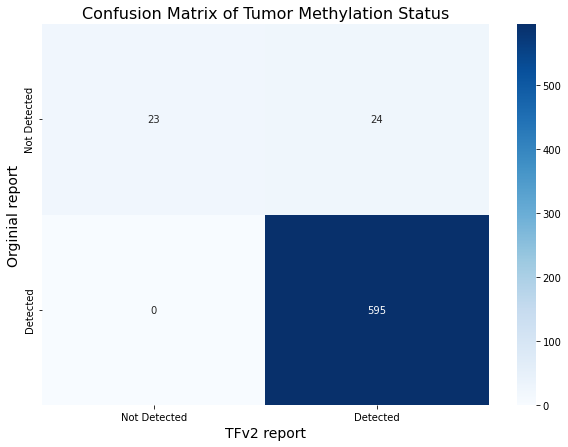

Cohen's Kappa: 0.64


In [15]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow157_2['Tumor_methylation_status_mapped'] = df_sow157_2['Tumor_methylation_status'].map(map_status)
df_sow157_final['Tumor_methylation_status_mapped'] = df_sow157_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow157_2['Tumor_methylation_status_mapped'].notna() & df_sow157_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow157_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow157_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [16]:
df_sow157_2.Visit_name.value_counts()

C1D1     503
C1D1*      2
Name: Visit_name, dtype: int64

In [169]:
# Create a mask for the specific case
mask = (df_sow157_2['Tumor_methylation_status_mapped'] == 0) & (df_sow157_final['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow157_final[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C1D1    21
Name: Visit_name, dtype: int64


In [17]:
df_sow157_2.Sample_status.value_counts()

SUCCESS    643
FAIL        12
Name: Sample_status, dtype: int64

In [18]:
df_sow157_final.Tumor_methylation_status.value_counts()

Detected        619
Not Detected     23
Name: Tumor_methylation_status, dtype: int64

# SOW164 TFv2 update (Lung/Breast)

## Data preocessing

In [167]:
# # Readin cummulative reports 

# # SOW164 need to check the different versions of the delivered report
# df_sow164_all = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20231106_AstraZeneca_SOW164_46Samples_InfinityReport.csv", header = 0) 

# print("Total sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.Patient_ID.nunique()) + "\n")

# df_sow164_all.head()

Total sample size of SOW164 Infinity cumulative batches is 4493

Total unique sample size of SOW164 Infinity cumulative batches is 46

Total unique patient sample size of SOW164 Infinity cumulative batches is 2



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [348]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

df_sow164_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW164_Infinity/AZN_SOW164_01/20240613_AstraZeneca_SOW164_46Samples_TFv2_InfinityReport.csv", header = 1) 

print("Total sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.shape[0]) + "\n") 
print("Total unique sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.Patient_ID.nunique()) + "\n")

df_sow164_all.head()

Total sample size of SOW164 Infinity cumulative batches is 4493

Total unique sample size of SOW164 Infinity cumulative batches is 46

Total unique patient sample size of SOW164 Infinity cumulative batches is 2



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [349]:
# Remove duplication
df_sow164_dedup = df_sow164_all.drop_duplicates(subset = "GHSampleID")
df_sow164_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
157,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
230,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
388,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
458,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [350]:
# Pull "runid" from ghdb
df_sow164_1 = df_sow164_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow164_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow164_1 = df_sow164_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow164_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7


In [351]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow164_2, df_no_found = add_fc_dir_column(df_sow164_1)

print("Total sample size of SOW164 Infinity cumulative batches with fc_dir is " + str(df_sow164_1.shape[0]) + "\n") 
print("Total sample size of SOW164 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow164_2.head()



Total sample size of SOW164 Infinity cumulative batches with fc_dir is 46

Total sample size of SOW164 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510


## Generate Lung/Breast S3 MB caller outputs for SOW164
#### Notes:
    1. No cancer type provided. But based on the Patient_ID, "Set1" is lung and "Set3" is breast.
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [6]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW164_jobs"
    output_dir = f"{workdir}/MB_module_SOW164_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:40:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [7]:
#run the function to generate all the MB S3 Lung caller ouputs for SOW164 batch 
run_bip_epigenomics_module_wrapper_slurm(df_sow164_2, 
                      f"{work_dir}")

Submitted batch job 86951286
Submitted batch job 86951287
Submitted batch job 86951288
Submitted batch job 86951289
Submitted batch job 86951290
Submitted batch job 86951291
Submitted batch job 86951292
Submitted batch job 86951293
Submitted batch job 86951294
Submitted batch job 86951295
Submitted batch job 86951296
Submitted batch job 86951297
Submitted batch job 86951298
Submitted batch job 86951299
Submitted batch job 86951300
Submitted batch job 86951301
Submitted batch job 86951302
Submitted batch job 86951303
Submitted batch job 86951304
Submitted batch job 86951305
Submitted batch job 86951306
Submitted batch job 86951307
Submitted batch job 86951308
Submitted batch job 86951309
Submitted batch job 86951310
Submitted batch job 86951311
Submitted batch job 86951312
Submitted batch job 86951313
Submitted batch job 86951314
Submitted batch job 86951315
Submitted batch job 86951316
Submitted batch job 86951317
Submitted batch job 86951318
Submitted batch job 86951319
Submitted batc

In [354]:
# Set1 are dilutions of the same lung pool, and set3 are dilutions of the single breast pool.
df_sow164_3.Patient_ID.value_counts()

MR_Set-1    23
MR_Set-3    23
Name: Patient_ID, dtype: int64

In [353]:
# Retrieve MB S3 lung or breast caller score
# Set1 are dilutions of the same lung pool, and set3 are dilutions of the single breast pool.

df_sow164_3 = df_sow164_2.copy()

df_sow164_3["MB_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW164_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow164_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]

    # This is a mixed cancer type cohort
    patient_id = crc_row["Patient_ID"]
    if patient_id == "MR_Set-1":
        msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_lung_call.hdr.tsv"
    else:
        msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_breast_call.hdr.tsv"
        print(patient_id)


    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow164_3.at[index, "MB_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow164_3.loc[problematic_rows]

print("Total sample size of SOW157 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow164_3.head()


MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
MR_Set-3
Total sample size of SOW157 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.159279
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.935363
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.925020
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.626208
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-15.650977


## Generate the epiTFv2 gamma score results

In [355]:
# Temporary solution for TFv2gamma score generation
df_sow164_3 = df_sow164_3[df_sow164_3['Sample_status'] != "FAIL"]
df_sow164_3.shape

# Save the data
df_sow164_3.to_csv(f"{work_dir}/df_sow164_3.csv", index = False)

In [356]:
# Step 1: save the input csv file
df_sow164_3 = pd.read_csv(f"{work_dir}/df_sow164_3.csv", header = 0)
df_sow164_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW164_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [27]:
# # Step 2 generate the slurm script

# # Define the contents of the slurm script
# # Parts to updates
#     # sample_list; out_path; slurm_script_path

# slurm_script_content = f"""#! /bin/sh
# #SBATCH --get-user-env
# #SBATCH --job-name TFv2gamma_pancanTF
# #SBATCH --partition dev
# #SBATCH --mem-per-cpu 40G
# #SBATCH --cpus-per-task 1
# #SBATCH --ntasks-per-node 1
# #SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
# #SBATCH --array 2-1000%300

# module load python/3.9.6;
# export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
# source $INSTALL_DIR/.py3_venv/bin/activate;
# export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

# sample_list={work_dir}/df_sow164_3.csv
# out_path="{TFv2gamma_output_dir}"
# mkdir -p $out_path

# # Extract details from CSV
# fc_dir=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $56}}' "$sample_list" | sed 's/\\/ghess\\//\\/ghsfa\\/projects\\//')
# sample_id=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $4}}' "$sample_list")

# # Prepend base path if fc_dir is relative
# base_path="/ghsfa/ivd/flowcentral"
# if [[ "$fc_dir" != /* ]]; then
#     fc_dir="${{base_path}}/${{fc_dir}}"
# fi

# # Construct paths
# sample_path="${{fc_dir}}/${{sample_id}}"
# mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
# methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
# subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# # Run the code
# python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
# """

# # Save the slurm script to file
# slurm_script_path = f"{work_dir}/run_TFv2gamma_sow164.sh"
# with open(slurm_script_path, "w") as file:
#     file.write(slurm_script_content)

In [64]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow164_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow164.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [65]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow164.sh")

Submitted batch job 86990279


0

In [357]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow164_4 = df_sow164_3[df_sow164_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow164_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW164_output"

for index, row in df_sow164_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow164_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow164_5 = df_sow164_4.copy()
df_sow164_5.head()

Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_score,pred_frac_force
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.159279,0.006212
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.935363,0.002752
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.925020,0.006571
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.626208,0.003561
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-15.650977,0.001942


### For checking troubleshooting purposes on TFv2gamma


In [52]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [56]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [68]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of SOW157 based on "TFv2" rule 

In [358]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run lung caller cutoffs for the SOW: MB18: -22.421763; MB90: -20.941267 for patient id == "MR_Set-1"
df_164_lung = df_sow164_5[df_sow164_5['Patient_ID'] == "MR_Set-1"]
df_sow164_updated_1 = update_tumor_methylation_status(df_164_lung, 'MB_score', -22.421763, -20.941267)

# Run breast caller cutoffs for the SOW: MB18: -22.291021; MB90: -21.488155 for patient id == "MR_Set-3"
df_164_breast = df_sow164_5[df_sow164_5['Patient_ID'] == "MR_Set-3"]
df_sow164_updated_2 = update_tumor_methylation_status(df_164_breast, 'MB_score', -22.291021, -21.488155)

# Concatenate the dataframes
df_sow164_updated = pd.concat([df_sow164_updated_1, df_sow164_updated_2], ignore_index=True)

df_sow164_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_score,pred_frac_force
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.159279,0.006212
1,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.925020,0.006571
2,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-15.650977,0.001942
3,MR_MATRIX,MR_set 1_s2,A0837758,B00481342,MR_Set-1,C3D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,56.64,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1651.0,0.201,NaN,NaN,Detected,0.003473,NaN,Not evaluable,Not Detected,15.964,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-9.603361,0.003473
4,MR_MATRIX,MR_set 1_s3,A0837759,B00481340,MR_Set-1,C4D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,56.89,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1634.0,0.000,NaN,NaN,Detected,0.001744,NaN,Not evaluable,Detected,14.456,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-14.024041,0.001744


In [359]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow164_5_sub = df_sow164_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow164_5_sub_dedup = df_sow164_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW164 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow164_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow164_all_dedup = df_sow164_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW164 Infinity cumulative batches is " + str(df_sow164_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow164_all_dedup.Sample_status.value_counts()


Total sample size of SOW164 Infinity cumulative batches with updated MB score and TFv2gamma is 46

Total sample size of original SOW164 Infinity cumulative batches is 46



SUCCESS    46
Name: Sample_status, dtype: int64

In [360]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow164_all_dedup.merge(df_sow164_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow164_final = df_merged[df_sow164_all_dedup.columns]

# Save the data
df_sow164_final.to_csv(f"{work_dir}/df_sow164_final.csv", index = False)

df_sow164_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [361]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow164_all.merge(df_sow164_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow164_final_all = df_merged[df_sow164_all.columns]

# Save the data
df_sow164_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW164_46Samples_TFv2_InfinityReport.csv", index = False)

df_sow164_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [365]:
df_sow164_final_all.shape

(4493, 56)

In [363]:
df_sow164_final.shape

(46, 56)

In [18]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow164_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW164_46Samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow164_final_all_new = suppress_methylation_score_higher_than_1(df_sow164_final_all)

# Save the data
df_sow164_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW164_46Samples_TFv2_InfinityReport.csv", index = False)

## Data Visualization

### Confusion Matrix

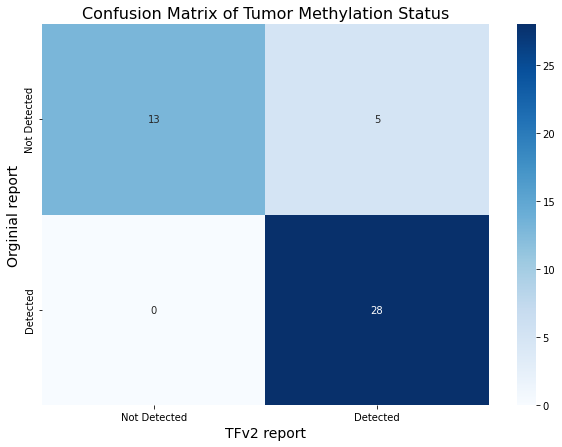

Cohen's Kappa: 0.76


In [364]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow164_2['Tumor_methylation_status_mapped'] = df_sow164_2['Tumor_methylation_status'].map(map_status)
df_sow164_final['Tumor_methylation_status_mapped'] = df_sow164_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow164_2['Tumor_methylation_status_mapped'].notna() & df_sow164_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow164_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow164_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# SOW165 TFv2 update (CRC)

## Data preocessing

In [221]:
# # Readin cummulative reports 

# # SOW need to check the different versions of the delivered report
# df_sow165_all = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20230928_AstraZeneca_SOW165_50Samples_InfinityReport.csv", header = 1) 

# print("Total sample size of SOW165 Infinity cumulative batches is " + str(df_sow165_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW165 Infinity cumulative batches is " + str(df_sow165_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW165 Infinity cumulative batches is " + str(df_sow165_all.Patient_ID.nunique()) + "\n")

# df_sow165_all.head()

Total sample size of SOW165 Infinity cumulative batches is 1725

Total unique sample size of SOW165 Infinity cumulative batches is 50

Total unique patient sample size of SOW165 Infinity cumulative batches is 50



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.013425,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,NaN,Not Applicable,Not Applicable
1,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FANCA,16,89816220.0,32.0,R1053C,G>A,c.3157C>T,NM_000135.4,51.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99981297,rs376103033,Uncertain_significance,401380.0,NaN,NaN,2483.0,3.86,NaN,NaN,Detected,0.013425,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,NaN,Not Applicable,Not Applicable
2,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FOXO1,13,41133978.0,2.0,S550S,C>T,c.1650G>A,NM_002015.4,50.53,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV65425690,rs368042937,NaN,NaN,NaN,NaN,3750.0,3.86,NaN,NaN,Detected,0.013425,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,NaN,Not Applicable,Not Applicable
3,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,WEE1,11,9598173.0,4.0,R329Q,G>A,c.986G>A,NM_003390.4,50.33,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs202076024,NaN,NaN,NaN,NaN,2749.0,3.86,NaN,NaN,Detected,0.013425,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,NaN,Not Applicable,Not Applicable
4,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,EIF4B,12,53421802.0,8.0,Y270C,A>G,c.809A>G,NM_001300821.3,50.11,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs755086357,NaN,NaN,NaN,NaN,2719.0,3.86,NaN,NaN,Detected,0.013425,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,NaN,Not Applicable,Not Applicable


In [366]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

df_sow165_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW165_Infinity/AZN_SOW165_Infinity_01/tumor_boarding/20240620_AstraZeneca_SOW165_50Samples_TFv2_InfinityReport.csv", header = 1) 

print("Total sample size of SOW165 Infinity cumulative batches is " + str(df_sow165_all.shape[0]) + "\n") 
print("Total unique sample size of SOW165 Infinity cumulative batches is " + str(df_sow165_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW165 Infinity cumulative batches is " + str(df_sow165_all.Patient_ID.nunique()) + "\n")

df_sow165_all.head()

Total sample size of SOW165 Infinity cumulative batches is 1725

Total unique sample size of SOW165 Infinity cumulative batches is 50

Total unique patient sample size of SOW165 Infinity cumulative batches is 50



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
1,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FANCA,16,89816220.0,32.0,R1053C,G>A,c.3157C>T,NM_000135.4,51.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99981297,rs376103033,Uncertain_significance,401380.0,NaN,NaN,2483.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
2,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FOXO1,13,41133978.0,2.0,S550S,C>T,c.1650G>A,NM_002015.4,50.53,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV65425690,rs368042937,NaN,NaN,NaN,NaN,3750.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
3,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,WEE1,11,9598173.0,4.0,R329Q,G>A,c.986G>A,NM_003390.4,50.33,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs202076024,NaN,NaN,NaN,NaN,2749.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
4,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,EIF4B,12,53421802.0,8.0,Y270C,A>G,c.809A>G,NM_001300821.3,50.11,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs755086357,NaN,NaN,NaN,NaN,2719.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable


In [367]:
# Remove duplication
df_sow165_dedup = df_sow165_all.drop_duplicates(subset = "GHSampleID")
df_sow165_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.026930,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
39,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
79,CHIP_MATRIX,CRC_s3,A0837805,B00481388,CRC_s3,NaN,0.0,FAIL,Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.200,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
80,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Not Detected,0.000000,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
100,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable


In [368]:
# Pull "runid" from ghdb
df_sow165_1 = df_sow165_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow165_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow165_1 = df_sow165_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow165_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.026930,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
1,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
2,CHIP_MATRIX,CRC_s3,A0837805,B00481388,CRC_s3,NaN,0.0,FAIL,Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.200,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
3,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Not Detected,0.000000,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
4,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7


In [369]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow165_2, df_no_found = add_fc_dir_column(df_sow165_1)

print("Total sample size of SOW165 Infinity cumulative batches with fc_dir is " + str(df_sow165_2.shape[0]) + "\n") 
print("Total sample size of SOW165 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow165_2.head()



Total sample size of SOW165 Infinity cumulative batches with fc_dir is 50

Total sample size of SOW165 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.026930,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
1,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
2,CHIP_MATRIX,CRC_s3,A0837805,B00481388,CRC_s3,NaN,0.0,FAIL,Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.200,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
3,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Not Detected,0.000000,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
4,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7,/ghsfa/ivd/flowcentral/230908_A00770_0766_BHCF35DSX7


## Generate CRC S3 MB caller outputs for this SOW
#### Notes:
    1. No cancer type provided but patient id include key word "CRC_"??
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [6]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW165_jobs"
    output_dir = f"{workdir}/MB_module_SOW165_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:40:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [7]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow165_2, 
                      f"{work_dir}")

Submitted batch job 86993392
Submitted batch job 86993394
Submitted batch job 86993396
Submitted batch job 86993398
Submitted batch job 86993400
Submitted batch job 86993403
Submitted batch job 86993405
Submitted batch job 86993407
Submitted batch job 86993408
Submitted batch job 86993410
Submitted batch job 86993411
Submitted batch job 86993412
Submitted batch job 86993413
Submitted batch job 86993414
Submitted batch job 86993415
Submitted batch job 86993416
Submitted batch job 86993417
Submitted batch job 86993418
Submitted batch job 86993419
Submitted batch job 86993421
Submitted batch job 86993422
Submitted batch job 86993425
Submitted batch job 86993427
Submitted batch job 86993429
Submitted batch job 86993431
Submitted batch job 86993433
Submitted batch job 86993436
Submitted batch job 86993437
Submitted batch job 86993438
Submitted batch job 86993439
Submitted batch job 86993440
Submitted batch job 86993441
Submitted batch job 86993442
Submitted batch job 86993443
Submitted batc

In [370]:
# Retrieve MB S3 crc caller score

df_sow165_3 = df_sow165_2.copy()

df_sow165_3["MB_crc_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW165_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow165_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_crc_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow165_3.at[index, "MB_crc_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow165_3.loc[problematic_rows]

print("Total sample size of SOW165 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow165_3.head()


Total sample size of SOW165 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_crc_score
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.026930,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,16.473182
1,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,9.670000
2,CHIP_MATRIX,CRC_s3,A0837805,B00481388,CRC_s3,NaN,0.0,FAIL,Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.200,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,13.242087
3,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Not Detected,0.000000,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-20.828909
4,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7,/ghsfa/ivd/flowcentral/230908_A00770_0766_BHCF35DSX7,-19.358102


## Generate the epiTFv2 gamma score results

In [371]:
# Temporary solution for TFv2gamma score generation
df_sow165_3 = df_sow165_3[df_sow165_3['Sample_status'] != "FAIL"]
df_sow165_3.shape

# Save the data
df_sow165_3.to_csv(f"{work_dir}/df_sow165_3.csv", index = False)

In [372]:
# Step 1: save the input csv file
df_sow165_3 = pd.read_csv(f"{work_dir}/df_sow165_3.csv", header = 0)
df_sow165_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW165_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [24]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow165_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow165.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [25]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow165.sh")

Submitted batch job 86995964


0

In [373]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow165_4 = df_sow165_3[df_sow165_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow165_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW165_output"

for index, row in df_sow165_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow165_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow165_5 = df_sow165_4.copy()
df_sow165_5.head()

Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_crc_score,pred_frac_force
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.026930,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,16.473182,0.02693
1,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,9.670000,0.014869
2,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Not Detected,0.000000,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-20.828909,0.000015
3,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7,/ghsfa/ivd/flowcentral/230908_A00770_0766_BHCF35DSX7,-19.358102,0.003115
4,CHIP_MATRIX,CRC_s6,A0837808,B00481385,CRC_s6,NaN,1.0,SUCCESS,NaN,SNV,NaN,MSH3,5,80057497.0,13.0,K632K,A>G,c.1896A>G,NM_002439.5,50.87,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs201737845,NaN,NaN,NaN,NaN,683.0,7.46,NaN,NaN,Detected,0.000779,NaN,Not evaluable,Not Detected,128.960,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7,/ghsfa/ivd/flowcentral/230908_A00770_0766_BHCF35DSX7,-17.013175,0.000779


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [374]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run crc caller cutoffs for the SOW: MB18: -22.4522; MB90: -21.249985
df_sow165_updated = update_tumor_methylation_status(df_sow165_5, 'MB_crc_score', -22.4522, -21.249985)

df_sow165_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_crc_score,pred_frac_force
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,16.473182,0.02693
1,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,9.670000,0.014869
2,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Detected,0.000015,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-20.828909,0.000015
3,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7,/ghsfa/ivd/flowcentral/230908_A00770_0766_BHCF35DSX7,-19.358102,0.003115
4,CHIP_MATRIX,CRC_s6,A0837808,B00481385,CRC_s6,NaN,1.0,SUCCESS,NaN,SNV,NaN,MSH3,5,80057497.0,13.0,K632K,A>G,c.1896A>G,NM_002439.5,50.87,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs201737845,NaN,NaN,NaN,NaN,683.0,7.46,NaN,NaN,Detected,0.000779,NaN,Not evaluable,Not Detected,128.960,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable,230908_A00770_0766_BHCF35DSX7,/ghsfa/ivd/flowcentral/230908_A00770_0766_BHCF35DSX7,-17.013175,0.000779


In [375]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow165_5_sub = df_sow165_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow165_5_sub_dedup = df_sow165_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW165 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow165_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow165_all_dedup = df_sow165_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW165 Infinity cumulative batches is " + str(df_sow165_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow165_all_dedup.Sample_status.value_counts()


Total sample size of SOW165 Infinity cumulative batches with updated MB score and TFv2gamma is 49

Total sample size of original SOW165 Infinity cumulative batches is 50



SUCCESS    49
FAIL        1
Name: Sample_status, dtype: int64

In [376]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow165_all_dedup.merge(df_sow165_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow165_final = df_merged[df_sow165_all_dedup.columns]

# Save the data
df_sow165_final.to_csv(f"{work_dir}/df_sow165_final.csv", index = False)

df_sow165_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
1,CHIP_MATRIX,CRC_s2,A0837804,B00481363,CRC_s2,NaN,1.0,SUCCESS,NaN,SNV,NaN,XPC,3,14200118.0,9.0,R422Q,C>T,c.1265G>A,NM_004628.5,51.37,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105128941,rs369681862,NaN,NaN,NaN,NaN,4803.0,1.47,NaN,NaN,Detected,0.014869,19.06,Low,Not Detected,39.208,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
2,CHIP_MATRIX,CRC_s3,A0837805,B00481388,CRC_s3,NaN,0.0,FAIL,Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.200,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
3,CHIP_MATRIX,CRC_s4,A0837806,B00481387,CRC_s4,NaN,1.0,SUCCESS,NaN,SNV,NaN,PAX7,1,19027246.0,6.0,G296S,G>A,c.886G>A,NM_001135254.2,50.78,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370742910,NaN,NaN,NaN,NaN,4281.0,1.01,NaN,NaN,Detected,0.000015,6.53,Low,Not Detected,105.040,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
4,CHIP_MATRIX,CRC_s5,A0837807,B00481386,CRC_s5,NaN,1.0,SUCCESS,Possible Contamination Warning,SNV,NaN,MLST8,16,2258547.0,8.0,P265P,C>T,c.795C>T,NM_001199173.3,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374909597,NaN,NaN,NaN,NaN,2103.0,20.03,NaN,NaN,Detected,0.003115,1.89,Low,Not Detected,23.036,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable


In [377]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow165_all.merge(df_sow165_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow165_final_all = df_merged[df_sow165_all.columns]

# Save the data
df_sow165_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW165_50Samples_TFv2_InfinityReport.csv", index = False)

df_sow165_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FZD7,2,202900348.0,1.0,T326T,G>A,c.978G>A,NM_003507.2,51.93,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs148824946,NaN,NaN,NaN,NaN,2585.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
1,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FANCA,16,89816220.0,32.0,R1053C,G>A,c.3157C>T,NM_000135.4,51.54,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99981297,rs376103033,Uncertain_significance,401380.0,NaN,NaN,2483.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
2,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,FOXO1,13,41133978.0,2.0,S550S,C>T,c.1650G>A,NM_002015.4,50.53,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV65425690,rs368042937,NaN,NaN,NaN,NaN,3750.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
3,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,WEE1,11,9598173.0,4.0,R329Q,G>A,c.986G>A,NM_003390.4,50.33,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs202076024,NaN,NaN,NaN,NaN,2749.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable
4,CHIP_MATRIX,CRC_s1,A0837803,B00481365,CRC_s1,NaN,1.0,SUCCESS,NaN,SNV,NaN,EIF4B,12,53421802.0,8.0,Y270C,A>G,c.809A>G,NM_001300821.3,50.11,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs755086357,NaN,NaN,NaN,NaN,2719.0,3.86,NaN,NaN,Detected,0.02693,12.29,Low,Not Detected,32.812,3.5,0,08/10/2023,NaN,09/21/2023,CRC,Not Applicable,Not Applicable


In [378]:
df_sow165_final_all.shape

(1725, 56)

In [35]:
df_sow165_final.shape

(50, 56)

In [19]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow165_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW165_50Samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow165_final_all_new = suppress_methylation_score_higher_than_1(df_sow165_final_all)

# Save the data
df_sow165_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW165_50Samples_TFv2_InfinityReport.csv", index = False)

## Data Visualization

### Confusion Matrix

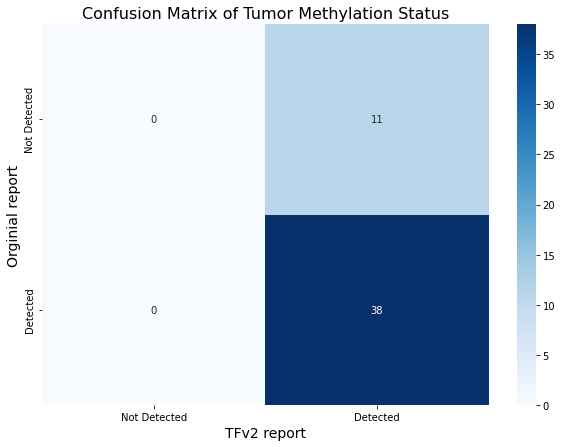

Cohen's Kappa: 0.00


In [379]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow165_2['Tumor_methylation_status_mapped'] = df_sow165_2['Tumor_methylation_status'].map(map_status)
df_sow165_final['Tumor_methylation_status_mapped'] = df_sow165_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow165_2['Tumor_methylation_status_mapped'].notna() & df_sow165_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow165_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow165_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# SOW175 TFv2 update (Breast)

## Data preocessing

In [38]:
# # Readin cummulative reports 

# # SOW need to check the different versions of the delivered report
# # Not able to retrieve two files together as a cumulative report using mr_pipeline.py
# df_sow175_1 = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20240227_AstraZeneca_SOW175_Batch1_66Samples_InfinityReport.csv", header = 1) 
# df_sow175_2 = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20240313_AstraZeneca_SOW175Monitoring_Infinity_01_34Samples_InfinityReport.csv", header = 1) 

# # Concatenate the dataframes
# df_sow175_all = pd.concat([df_sow175_1, df_sow175_2], ignore_index=True)

# print("Total sample size of SOW175 Infinity cumulative batches is " + str(df_sow175_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW175 Infinity cumulative batches is " + str(df_sow175_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW175 Infinity cumulative batches is " + str(df_sow175_all.Patient_ID.nunique()) + "\n")

# df_sow175_all.head()

Total sample size of SOW175 Infinity cumulative batches is 6331

Total unique sample size of SOW175 Infinity cumulative batches is 100

Total unique patient sample size of SOW175 Infinity cumulative batches is 35



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.166982,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,NaN,Not Applicable,Not Applicable
1,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,CDKN1A,6,36652117.0,3.0,T80M,C>T,c.239C>T,NM_000389.5,51.05,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs114149607,NaN,NaN,NaN,NaN,3542.0,23.37,NaN,NaN,Detected,0.166982,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,NaN,Not Applicable,Not Applicable
2,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,NUMA1,11,71725345.0,16.0,K1068K,C>T,c.3204G>A,NM_001286561.2,49.79,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3607.0,23.37,NaN,NaN,Detected,0.166982,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,NaN,Not Applicable,Not Applicable
3,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,MSH6,2,48018236.0,2.0,S144I,G>T,c.431G>T,NM_000179.3,49.49,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52277295,rs3211299,Benign,50035.0,NaN,NaN,3473.0,23.37,NaN,NaN,Detected,0.166982,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,NaN,Not Applicable,Not Applicable
4,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,PSMB8,6,32809349.0,5.0,NaN,T>C,c.-3339A>G,NM_001290043.2,49.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs55853041,NaN,NaN,NaN,NaN,3770.0,23.37,NaN,NaN,Detected,0.166982,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,NaN,Not Applicable,Not Applicable


In [26]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

df_sow175_ori_1 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW175_Infinity/AZN_SOW175_Infinity_01/20240620_AstraZeneca_SOW175_66Samples_TFv2_InfinityReport.csv", header = 0) 
df_sow175_ori_2 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW175Monitoring_Infinity/AZN_SOW175Monitoring_Infinity_01/tb/20240620_AstraZeneca_SOW175_34Samples_TFv2_RevealInfinityReport.csv", header = 0) 


# Concatenate the dataframes
# Important note !!!!! The data structure of df_sow175_ori_1, df_sow175_ori_2 are different. The concatnation is not perfect but it's fine as we handel different reports separately later.
df_sow175_all = pd.concat([df_sow175_ori_1, df_sow175_ori_2], ignore_index=True)

print("Total sample size of SOW175 Infinity cumulative batches is " + str(df_sow175_all.shape[0]) + "\n") 
print("Total unique sample size of SOW175 Infinity cumulative batches is " + str(df_sow175_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW175 Infinity cumulative batches is " + str(df_sow175_all.Patient_ID.nunique()) + "\n")

df_sow175_all.head()

Total sample size of SOW175 Infinity cumulative batches is 4511

Total unique sample size of SOW175 Infinity cumulative batches is 100

Total unique patient sample size of SOW175 Infinity cumulative batches is 35



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDKN1A,6,36652117.0,3.0,T80M,C>T,c.239C>T,NM_000389.5,51.05,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs114149607,NaN,NaN,NaN,NaN,3542.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,NUMA1,11,71725345.0,16.0,K1068K,C>T,c.3204G>A,NM_001286561.2,49.79,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3607.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,MSH6,2,48018236.0,2.0,S144I,G>T,c.431G>T,NM_000179.3,49.49,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52277295,rs3211299,Benign,50035.0,NaN,NaN,3473.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PSMB8,6,32809349.0,5.0,NaN,T>C,c.-3339A>G,NM_001290043.2,49.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs55853041,NaN,NaN,NaN,NaN,3770.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN


In [27]:
# Remove duplication
df_sow175_dedup = df_sow175_all.drop_duplicates(subset = "GHSampleID")
df_sow175_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
104,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.160150,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
161,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
244,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
385,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN


In [28]:
# Pull "runid" from ghdb
df_sow175_1 = df_sow175_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow175_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow175_1 = df_sow175_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow175_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7
1,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.160150,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7
2,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7
3,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7
4,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7


In [29]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow175_2, df_no_found = add_fc_dir_column(df_sow175_1)

print("Total sample size of SOW175 Infinity cumulative batches with fc_dir is " + str(df_sow175_2.shape[0]) + "\n") 
print("Total sample size of SOW175 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow175_2.head()



Total sample size of SOW175 Infinity cumulative batches with fc_dir is 100

Total sample size of SOW175 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735
1,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.160150,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735
2,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735
3,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735
4,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735


## Generate Breast S3 MB caller outputs for this SOW
#### Notes:
    1. It's a breast cohort even though some samples have no cancer type provided.
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [32]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW175_jobs"
    output_dir = f"{workdir}/MB_module_SOW175_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=40gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:50:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [33]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow175_2, 
                      f"{work_dir}")

Submitted batch job 87070523
Submitted batch job 87070524
Submitted batch job 87070525
Submitted batch job 87070526
Submitted batch job 87070527
Submitted batch job 87070528
Submitted batch job 87070529
Submitted batch job 87070530
Submitted batch job 87070531
Submitted batch job 87070532
Submitted batch job 87070533
Submitted batch job 87070534
Submitted batch job 87070535
Submitted batch job 87070536
Submitted batch job 87070537
Submitted batch job 87070538
Submitted batch job 87070539
Submitted batch job 87070540
Submitted batch job 87070541
Submitted batch job 87070542
Submitted batch job 87070543
Submitted batch job 87070544
Submitted batch job 87070545
Submitted batch job 87070546
Submitted batch job 87070547
Submitted batch job 87070548
Submitted batch job 87070549
Submitted batch job 87070550
Submitted batch job 87070551
Submitted batch job 87070552
Submitted batch job 87070553
Submitted batch job 87070554
Submitted batch job 87070555
Submitted batch job 87070556
Submitted batc

In [385]:
# Retrieve MB S3 Breast caller score

df_sow175_3 = df_sow175_2.copy()

df_sow175_3["MB_breast_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW175_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow175_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_breast_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow175_3.at[index, "MB_breast_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow175_3.loc[problematic_rows]

print("Total sample size of SOW175 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow175_3.head()


Total sample size of SOW175 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_breast_score
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,15.240787
1,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.160150,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,12.226960
2,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,16.193697
3,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,8.577595
4,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,11.197017


## Generate the epiTFv2 gamma score results

In [386]:
# Temporary solution for TFv2gamma score generation
df_sow175_3 = df_sow175_3[df_sow175_3['Sample_status'] != "FAIL"]
df_sow175_3.shape

# Save the data
df_sow175_3.to_csv(f"{work_dir}/df_sow175_3.csv", index = False)

In [30]:
# Step 1: save the input csv file
df_sow175_3 = pd.read_csv(f"{work_dir}/df_sow175_3.csv", header = 0)
df_sow175_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW175_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [9]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow175_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow175.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [10]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow175.sh")

Submitted batch job 87071650


0

In [31]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow175_4 = df_sow175_3[df_sow175_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow175_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW175_output"

for index, row in df_sow175_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow175_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW175 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow175_5 = df_sow175_4.copy()
df_sow175_5.head()

Total sample size of SOW175 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_breast_score,pred_frac_force
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,15.240787,0.274028
1,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.160150,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,12.226960,0.16015
2,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,16.193697,0.319489
3,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,8.577595,0.055704
4,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,11.197017,0.135919


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [32]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run breast caller cutoffs for the SOW: MB18: -22.291021; MB90: -21.488155
df_sow175_updated = update_tumor_methylation_status(df_sow175_5, 'MB_breast_score', -22.291021, -21.488155)

df_sow175_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_breast_score,pred_frac_force
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,15.240787,0.274028
1,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.16015,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,12.226960,0.16015
2,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,16.193697,0.319489
3,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,8.577595,0.055704
4,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN,240224_A01810_0326_BHTGLHDSX7,/ghsfa/ivd/flowcentral/240224_A01810_0326_BHTGLHDSX7.d0cdde36-ae49-4340-87cf-faccdebf6c3e.20240226051735,11.197017,0.135919


In [33]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow175_5_sub = df_sow175_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow175_5_sub_dedup = df_sow175_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW175 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow175_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow175_all_dedup = df_sow175_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW175 Infinity cumulative batches is " + str(df_sow175_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow175_all_dedup.Sample_status.value_counts()


Total sample size of SOW175 Infinity cumulative batches with updated MB score and TFv2gamma is 100

Total sample size of original SOW175 Infinity cumulative batches is 100



SUCCESS    100
Name: Sample_status, dtype: int64

### Handel Reveal and Infinity report separately

In [34]:
# For Reveal batches 
# Update the column values while maintaining the original column order not changed

df_merged_reveal = df_sow175_ori_2.merge(df_sow175_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged_reveal['Tumor_methylation_status'] = df_merged_reveal['Tumor_methylation_status_updated'].combine_first(df_merged_reveal['Tumor_methylation_status'])
df_merged_reveal['Tumor_methylation_score'] = df_merged_reveal['Tumor_methylation_score_updated'].combine_first(df_merged_reveal['Tumor_methylation_score'])
df_merged_reveal['ctDNA_detected'] = df_merged_reveal['Tumor_methylation_status_updated'].combine_first(df_merged_reveal['Tumor_methylation_status'])


# Drop the temporary updated columns
df_merged_reveal.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow175_reveal_final_all = df_merged_reveal[df_sow175_ori_2.columns]

# Save the data
df_sow175_reveal_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW175_34Samples_TFv2_RevealInfinityReport.csv", index = False)

df_sow175_reveal_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,D361DC00001,6519963353,A0966733,B00604976,E1002002,Breast,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.202595,19.448,3.5,0.0,12/05/2023,NaN,03/13/2024
1,D361DC00001,6519963352,A0966735,B00604974,E1002003,Breast,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.003547,21.996,3.5,0.0,12/05/2023,NaN,03/13/2024
2,D361DC00001,6515871505,A0966727,B00604963,E7802002,Breast,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.001073,54.600,3.5,0.0,12/05/2023,NaN,03/13/2024
3,D361DC00001,6517910395,A0966734,B00604973,E7802004,Breast,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.494148,310.960,3.5,0.0,12/05/2023,NaN,03/13/2024
4,D361DC00001,6520921920,A0966732,B00604975,E1002004,Breast,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.2154,121.160,3.5,0.0,12/05/2023,NaN,03/13/2024


In [35]:
df_sow175_reveal_final_all.GHSampleID.nunique()

34

In [36]:
# For Infinity report
# Update the column values while maintaining the original column order not changed

df_merged_infinity = df_sow175_ori_1.merge(df_sow175_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged_infinity['Tumor_methylation_status'] = df_merged_infinity['Tumor_methylation_status_updated'].combine_first(df_merged_infinity['Tumor_methylation_status'])
df_merged_infinity['Tumor_methylation_score'] = df_merged_infinity['Tumor_methylation_score_updated'].combine_first(df_merged_infinity['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged_infinity.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow175_infinity_final_all = df_merged_infinity[df_sow175_ori_1.columns]

# Save the data
df_sow175_infinity_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW175_66Samples_TFv2_InfinityReport.csv", index = False)

df_sow175_infinity_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable
1,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,CDKN1A,6,36652117.0,3.0,T80M,C>T,c.239C>T,NM_000389.5,51.05,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs114149607,NaN,NaN,NaN,NaN,3542.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable
2,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,NUMA1,11,71725345.0,16.0,K1068K,C>T,c.3204G>A,NM_001286561.2,49.79,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3607.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable
3,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,MSH6,2,48018236.0,2.0,S144I,G>T,c.431G>T,NM_000179.3,49.49,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52277295,rs3211299,Benign,50035.0,NaN,NaN,3473.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable
4,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1,SUCCESS,NaN,SNV,NaN,PSMB8,6,32809349.0,5.0,NaN,T>C,c.-3339A>G,NM_001290043.2,49.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs55853041,NaN,NaN,NaN,NaN,3770.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable


In [37]:
df_sow175_infinity_final_all.GHSampleID.nunique()

66

In [38]:
# For confusion table only!!
# Update the column values while maintaining the original column order not changed 

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow175_all_dedup.merge(df_sow175_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow175_final = df_merged[df_sow175_all_dedup.columns]

# Save the data
df_sow175_final.to_csv(f"{work_dir}/df_sow175_final.csv", index = False)

df_sow175_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D361DC00001,6218168025,A0965325,B00604943,E2302003,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ALK,2,30143494.0,1.0,P11L,G>A,c.32C>T,NM_004304.5,52.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767822322,Uncertain_significance,289006.0,NaN,NaN,3099.0,23.37,NaN,NaN,Detected,0.274028,19.85,Low,Not Detected,20.54,2.5,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D361DC00001,6603544747,A0965326,B00604946,E0301005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,53.60,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6000.0,7.14,NaN,NaN,Detected,0.16015,6.62,Low,Not Detected,86.32,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D361DC00001,6603697921,A0965327,B00604945,E0301005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,PDGFRB,5,149513239.0,6.0,E282K,C>T,c.844G>A,NM_002609.4,58.68,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs34586048,NaN,NaN,NaN,NaN,6762.0,6.45,NaN,NaN,Detected,0.319489,15.15,Low,Not Detected,154.44,3.5,NaN,12/08/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D361DC00001,6217824080,A0965328,B00604956,E0501006,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TAPBP,6,33273044.0,4.0,P197L,G>A,c.590C>T,NM_003190.5,51.42,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs149606847,NaN,NaN,NaN,NaN,2697.0,6.69,NaN,NaN,Detected,0.055704,88.80,High,Not Detected,17.16,4.0,NaN,01/03/2024,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D361DC00001,6516575225,A0965329,B00604955,E7802002,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CDH1,16,68847350.0,9.0,V424V,C>T,c.1272C>T,NM_004360.5,52.11,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs61756284,Benign/Likely_benign,140398.0,NaN,NaN,5452.0,7.24,NaN,NaN,Detected,0.135919,7.56,Low,Not Detected,148.20,3.5,NaN,12/05/2023,NaN,02/27/2024,Breast,Not Applicable,Not Applicable,NaN,NaN,NaN


In [397]:
df_sow175_infinity_final_all.shape

(4477, 56)

In [119]:
df_sow175_final.shape

(100, 59)

In [20]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow175_reveal_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW175_34Samples_TFv2_RevealInfinityReport.csv")
df_sow175_infinity_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW175_66Samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow175_reveal_final_all_new = suppress_methylation_score_higher_than_1(df_sow175_reveal_final_all)
df_sow175_infinity_final_all_new = suppress_methylation_score_higher_than_1(df_sow175_infinity_final_all)


# Save the data
df_sow175_reveal_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW175_34Samples_TFv2_RevealInfinityReport.csv", index = False)
df_sow175_infinity_final_all.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW175_66Samples_TFv2_InfinityReport.csv", index = False)

## Data Visualization

### Confusion Matrix

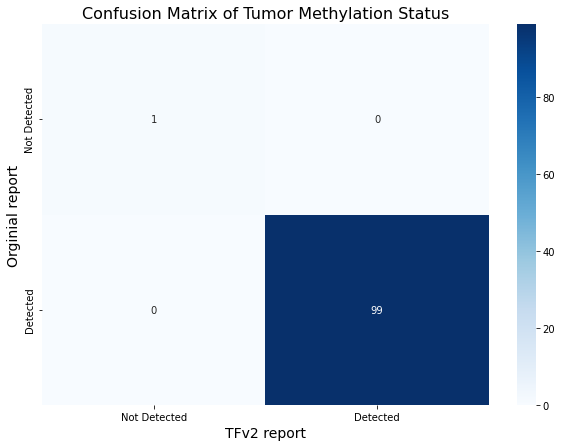

Cohen's Kappa: 1.00


In [39]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow175_2['Tumor_methylation_status_mapped'] = df_sow175_2['Tumor_methylation_status'].map(map_status)
df_sow175_final['Tumor_methylation_status_mapped'] = df_sow175_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow175_2['Tumor_methylation_status_mapped'].notna() & df_sow175_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow175_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow175_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# SOW176 TFv2 update (Endometrial Cancer)

## Data preocessing

In [126]:
# # Readin cummulative reports 

# # SOW need to check the different versions of the delivered report
# df_sow176_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176_Infinity/AZN_SOW176_Infinity_01/molecular_response/cumulative_report.csv", header = 1) 

# print("Total sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.Patient_ID.nunique()) + "\n")

# df_sow176_all.head()

Total sample size of SOW176 Infinity cumulative batches is 52860

Total unique sample size of SOW176 Infinity cumulative batches is 1406

Total unique patient sample size of SOW176 Infinity cumulative batches is 352



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
1,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,SDHA,5,233698.0,8.0,A334A,G>A,c.1002G>A,NM_004168.4,51.35,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99371911,rs144252500,NaN,NaN,NaN,NaN,2568.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
2,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,BABAM1,19,17389819.0,9.0,E318K,G>A,c.952G>A,NM_001033549.3,51.10,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3918.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
3,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,MYOD1,11,17741548.0,1.0,P73P,G>A,c.219G>A,NM_002478.5,49.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51455670,rs373565128,NaN,NaN,NaN,NaN,1985.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
4,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,GEN1,2,17963176.0,14.0,Q899H,G>C,c.2697G>C,NM_182625.5,49.19,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370541992,NaN,NaN,NaN,NaN,2889.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable


In [2]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

df_sow176_ori_1 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176_Infinity/AZN_SOW176_Infinity_01/tb/20240620_AstraZeneca_SOW176_352Samples_TFv2_InfinityReport.csv", header = 0) 
df_sow176_ori_2 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176Monitoring_Infinity/AZN_SOW176Monitoring_Infinity_01/tb/20240620_AstraZeneca_SOW176_998Samples_TFv2_RevealInfinityReport.csv", header = 0) 
df_sow176_ori_3 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176Monitoring_Infinity/AZN_SOW176Monitoring_Infinity_02/tb/20240620_AstraZeneca_SOW176_56Samples_TFv2_RevealInfinityReport.csv", header = 0) 

# Concatenate the dataframes
# Important note !!!!! The data structure of df_sow175_ori_1, df_sow175_ori_2 are different. The concatnation is not perfect but it's fine as we handel different reports separately later.
df_sow176_all = pd.concat([df_sow176_ori_1, df_sow176_ori_2, df_sow176_ori_3], ignore_index=True)

print("Total sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.shape[0]) + "\n") 
print("Total unique sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.Patient_ID.nunique()) + "\n")

df_sow176_all.head()

Total sample size of SOW176 Infinity cumulative batches is 22539

Total unique sample size of SOW176 Infinity cumulative batches is 1406

Total unique patient sample size of SOW176 Infinity cumulative batches is 352



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,SDHA,5,233698.0,8.0,A334A,G>A,c.1002G>A,NM_004168.4,51.35,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99371911,rs144252500,NaN,NaN,NaN,NaN,2568.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,BABAM1,19,17389819.0,9.0,E318K,G>A,c.952G>A,NM_001033549.3,51.10,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3918.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,MYOD1,11,17741548.0,1.0,P73P,G>A,c.219G>A,NM_002478.5,49.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51455670,rs373565128,NaN,NaN,NaN,NaN,1985.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,GEN1,2,17963176.0,14.0,Q899H,G>C,c.2697G>C,NM_182625.5,49.19,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370541992,NaN,NaN,NaN,NaN,2889.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN


In [3]:
# Remove duplication
df_sow176_dedup = df_sow176_all.drop_duplicates(subset = "GHSampleID")
df_sow176_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164000,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
46,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.000000,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
73,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.105663,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
207,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000582,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
226,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1.0,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.047770,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN


In [4]:
df_sow176_dedup.Cancertype.value_counts()

Endometrial Cancer    1406
Name: Cancertype, dtype: int64

In [44]:
# # Pull "runid" from ghdb
# df_sow176_1 = df_sow176_dedup.copy()

# # Define the IDs you want to query for
# ids = tuple(df_sow176_1['GHSampleID'].unique())

# # Generate the SQL query string
# query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# # Get the dataframe with "runid"
# sample_df = functions.run_sql_query(query)
# sample_df.head()

# # Merge "runid" 
# sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
# df_sow176_1 = df_sow176_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
# df_sow176_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0754_AHWK3NDSX7
1,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.000000,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7
2,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.072050,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A01537_0369_AHWHWKDSX7
3,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000955,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A01537_0369_AHWHWKDSX7
4,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.021274,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7


In [5]:
# Pull "runid" from ghdb
df_sow176_1 = df_sow176_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow176_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})

# Found some sample has duplicated runid which might due to re-run. So only the latest FC runs were saved.
# Extract the date from runid and convert to datetime format for accurate comparison
sample_df['run_date'] = pd.to_datetime(sample_df['runid'].str.extract(r'(\d{6})')[0], format='%y%m%d')
df_sow176_1 = df_sow176_1.merge(sample_df[['GHSampleID', 'runid', 'run_date']], on='GHSampleID', how="left")
df_sow176_1 = df_sow176_1.sort_values(by=['GHSampleID', 'run_date'], ascending=[True, False]).drop_duplicates(subset='GHSampleID', keep='first')
df_sow176_1 = df_sow176_1.drop(columns='run_date')

print("Total sample size of SOW176 Infinity cumulative batches after merging runid is " + str(df_sow176_1.shape[0])) 
df_sow176_1.head()


Total sample size of SOW176 Infinity cumulative batches after merging runid is 1406


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid
461,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7
511,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7
360,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7
469,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7
531,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7


In [6]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow176_2, df_no_found = add_fc_dir_column(df_sow176_1)

print("Total sample size of SOW176 Infinity cumulative batches with fc_dir is " + str(df_sow176_2.shape[0]) + "\n") 
print("Total sample size of SOW176 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow176_2.head()



Total sample size of SOW176 Infinity cumulative batches with fc_dir is 1406

Total sample size of SOW176 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir
461,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
511,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
360,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7,/ghsfa/ivd/flowcentral/240314_A00569_0747_AHTHJTDSX7
469,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
531,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7


## Generate Pancancer S3 MB caller outputs for this SOW
#### Notes:
    1. No cancer type provided
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [74]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW176_jobs"
    output_dir = f"{workdir}/MB_module_SOW176_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=60gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=01:00:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow176_2, 
                      f"{work_dir}")

In [7]:
# Retrieve MB S3 Pancancer caller score

df_sow176_3 = df_sow176_2.copy()

df_sow176_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW176_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow176_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow176_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow176_3.loc[problematic_rows]

print("Total sample size of SOW176 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow176_3.head()


Total sample size of SOW176 Infinity cumulative batches with NO MB output is 1



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score
461,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-20.217775
511,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-21.159409
360,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7,/ghsfa/ivd/flowcentral/240314_A00569_0747_AHTHJTDSX7,-22.174152
469,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-22.134603
531,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-22.018810


In [404]:
df_problematic.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score
1317,D9311C00001,6519140766,A0982932,B00626806,E7830013,C3D1,NaN,FAIL,Methylation Suppression Warning; Methylation Bias Warning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,01/17/2024,03/09/2022,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,NaN,9.1,240321_A01021_0640_AHWL3TDSX7,/ghsfa/ivd/flowcentral/240321_A01021_0640_AHWL3TDSX7,NaN


## Generate the epiTFv2 gamma score results

In [405]:
# Temporary solution for TFv2gamma score generation
df_sow176_3 = df_sow176_3[df_sow176_3['Sample_status'] != "FAIL"]
df_sow176_3.shape

# Save the data
df_sow176_3.to_csv(f"{work_dir}/df_sow176_3.csv", index = False)

In [46]:
# Step 1: save the input csv file
df_sow176_3 = pd.read_csv(f"{work_dir}/df_sow176_3.csv", header = 0)
df_sow176_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW176_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [134]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-2000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow176_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow176.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [135]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow176.sh")

Submitted batch job 87782997


0

In [8]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow176_4 = df_sow176_3[df_sow176_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow176_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW176_output"

for index, row in df_sow176_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow176_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW176 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow176_5 = df_sow176_4.copy()
df_sow176_5.head()

Total sample size of SOW176 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score,pred_frac_force
461,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-20.217775,0.000727
511,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-21.159409,0.000167
360,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7,/ghsfa/ivd/flowcentral/240314_A00569_0747_AHTHJTDSX7,-22.174152,0.000253
469,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-22.134603,0.000066
531,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-22.018810,0.000116


In [408]:
df_no_tfv2

""


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [9]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684
df_sow176_updated = update_tumor_methylation_status(df_sow176_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow176_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score,pred_frac_force
461,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,0.000727,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-20.217775,0.000727
511,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-21.159409,0.000167
360,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7,/ghsfa/ivd/flowcentral/240314_A00569_0747_AHTHJTDSX7,-22.174152,0.000253
469,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-22.134603,0.000066
531,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7,-22.018810,0.000116


In [10]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow176_5_sub = df_sow176_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow176_5_sub_dedup = df_sow176_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW176 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow176_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow176_all_dedup = df_sow176_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW176 Infinity cumulative batches is " + str(df_sow176_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow176_all_dedup.Sample_status.value_counts()


Total sample size of SOW176 Infinity cumulative batches with updated MB score and TFv2gamma is 1395

Total sample size of original SOW176 Infinity cumulative batches is 1406



SUCCESS    1395
FAIL         11
Name: Sample_status, dtype: int64

### Handel Monitoring and Infinity report Separately

In [12]:
# Concatenate the the two monitoring report
df_sow176_monitoring_all = pd.concat([df_sow176_ori_2, df_sow176_ori_3], ignore_index=True)

In [13]:
# For Minitoring reports

df_merged_monitoring = df_sow176_monitoring_all.merge(df_sow176_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged_monitoring['Tumor_methylation_status'] = df_merged_monitoring['Tumor_methylation_status_updated'].combine_first(df_merged_monitoring['Tumor_methylation_status'])
df_merged_monitoring['Tumor_methylation_score'] = df_merged_monitoring['Tumor_methylation_score_updated'].combine_first(df_merged_monitoring['Tumor_methylation_score'])
df_merged_monitoring['ctDNA_detected'] = df_merged_monitoring['Tumor_methylation_status_updated'].combine_first(df_merged_monitoring['Tumor_methylation_status'])


# Drop the temporary updated columns
df_merged_monitoring.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow176_monitoring_final_all = df_merged_monitoring[df_sow176_monitoring_all.columns]

# Save the data
df_sow176_monitoring_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW176_1054Samples_TFv2_RevealInfinityReport.csv", index = False)

df_sow176_monitoring_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,D9311C00001,6212633600,A0982320,B00619520,E0502001,Endometrial Cancer,NaN,C3D1,SUCCESS,NaN,Detected,Detected,0.000215,5.928,3.0,0.0,03/05/2024,11/12/2020,04/22/2024
1,D9311C00001,6213064328,A0982514,B00619511,E0502001,Endometrial Cancer,NaN,C7D1,SUCCESS,NaN,Detected,Detected,0.00027,11.336,3.0,0.0,03/05/2024,02/22/2021,04/22/2024
2,D9311C00001,6213064329,A0982515,B00619513,E0502002,Endometrial Cancer,NaN,C3D1,SUCCESS,NaN,Detected,Detected,0.000216,38.480,3.0,0.0,03/05/2024,05/03/2021,04/22/2024
3,D9311C00001,6214170302,A0982378,B00619443,E2101002,Endometrial Cancer,NaN,C3D1,SUCCESS,NaN,Not Detected,Not Detected,0.0,7.176,3.0,0.0,12/05/2023,04/13/2021,04/22/2024
4,D9311C00001,6214170303,A0982379,B00619445,E2101002,Endometrial Cancer,NaN,C7D1,SUCCESS,NaN,Not Detected,Not Detected,0.0,12.844,3.0,0.0,12/05/2023,07/06/2021,04/22/2024


In [30]:
df_sow176_monitoring_final_all.GHSampleID.nunique()

1054

In [14]:
# For Infinity report 

df_merged_infinity = df_sow176_ori_1.merge(df_sow176_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged_infinity['Tumor_methylation_status'] = df_merged_infinity['Tumor_methylation_status_updated'].combine_first(df_merged_infinity['Tumor_methylation_status'])
df_merged_infinity['Tumor_methylation_score'] = df_merged_infinity['Tumor_methylation_score_updated'].combine_first(df_merged_infinity['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged_infinity.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow176_infinity_final_all = df_merged_infinity[df_sow176_ori_1.columns]

# Save the data
df_sow176_infinity_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW176_352Samples_TFv2_InfinityReport.csv", index = False)

df_sow176_infinity_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
1,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,SDHA,5,233698.0,8.0,A334A,G>A,c.1002G>A,NM_004168.4,51.35,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99371911,rs144252500,NaN,NaN,NaN,NaN,2568.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
2,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,BABAM1,19,17389819.0,9.0,E318K,G>A,c.952G>A,NM_001033549.3,51.10,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3918.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
3,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,MYOD1,11,17741548.0,1.0,P73P,G>A,c.219G>A,NM_002478.5,49.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51455670,rs373565128,NaN,NaN,NaN,NaN,1985.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
4,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,GEN1,2,17963176.0,14.0,Q899H,G>C,c.2697G>C,NM_182625.5,49.19,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370541992,NaN,NaN,NaN,NaN,2889.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable


In [32]:
df_sow176_infinity_final_all.GHSampleID.nunique()

352

In [11]:
# For confusion table only!

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow176_all_dedup.merge(df_sow176_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow176_final = df_merged[df_sow176_all_dedup.columns]

# Save the data
df_sow176_final.to_csv(f"{work_dir}/df_sow176_final.csv", index = False)

df_sow176_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.0,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.105663,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1.0,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000582,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1.0,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.04777,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN


In [49]:
df_sow176_2.to_csv(f"{work_dir}/df_sow176_2.csv", index = False)


In [50]:
df_sow176_2.to_csv(f"{work_dir}/df_sow176_2.csv", index = False)

df_sow176_2 = pd.read_csv(f"{work_dir}/df_sow176_2.csv", header = 0)
print(df_sow176_2.shape)
df_sow176_2.head()

(1406, 61)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir
0,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
1,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
2,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7,/ghsfa/ivd/flowcentral/240314_A00569_0747_AHTHJTDSX7
3,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
4,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7


In [105]:
df_sow176_final_all.shape

(21485, 56)

In [34]:
df_sow176_final.shape

(1406, 59)

In [43]:
df_sow176_2.Tumor_methylation_status.isnull().sum()

11

In [35]:
df_sow176_final.Sample_comment.value_counts()

Low Diversity Warning                                                       29
GC Bias Warning                                                             24
Possible Contamination Warning                                              14
Low Diversity Warning; Methylation Suppression Warning                       4
Methylation Bias Warning                                                     3
Methylation Suppression Warning; Methylation Bias Warning                    3
Low On Target Rate Warning                                                   2
Low Diversity Warning; GC Bias Warning; Unusual Coverage Profile Warning     2
Low Diversity Warning; GC Bias Warning                                       1
Unusual Coverage Profile Warning                                             1
Unusual Coverage Profile, Low Diversity                                      1
Name: Sample_comment, dtype: int64

In [21]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow176_monitoring_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW176_1054Samples_TFv2_RevealInfinityReport.csv")
df_sow176_infinity_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW176_352Samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow176_monitoring_final_all_new = suppress_methylation_score_higher_than_1(df_sow176_monitoring_final_all)
df_sow176_infinity_final_all_new = suppress_methylation_score_higher_than_1(df_sow176_infinity_final_all)


# Save the data
df_sow176_monitoring_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW176_1054Samples_TFv2_RevealInfinityReport.csv", index = False)
df_sow176_infinity_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW176_352Samples_TFv2_InfinityReport.csv", index = False)

## Data Visualization

### Confusion Matrix

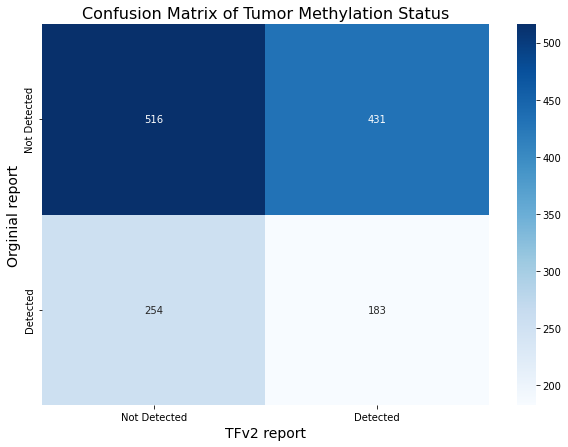

Cohen's Kappa: -0.03


In [52]:
# # This version of confusion matrix is NOT CORRECT due to it's matching based on index and the removing NaN step resulted in missing samples!!
# from sklearn.metrics import confusion_matrix, cohen_kappa_score

# # Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
# map_status = {"Detected": 1, "Not Detected": 0}

# df_sow176_2['Tumor_methylation_status_mapped'] = df_sow176_2['Tumor_methylation_status'].map(map_status)
# df_sow176_final['Tumor_methylation_status_mapped'] = df_sow176_final['Tumor_methylation_status'].map(map_status)

# # Remove NaN values before creating the confusion matrix
# valid_indices = df_sow176_2['Tumor_methylation_status_mapped'].notna() & df_sow176_final['Tumor_methylation_status_mapped'].notna()
# y_true = df_sow176_2[valid_indices]['Tumor_methylation_status_mapped'].values
# y_pred = df_sow176_final[valid_indices]['Tumor_methylation_status_mapped'].values

# # Generating the confusion matrix
# cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# # Plotting the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
# plt.xlabel('TFv2 report', fontsize=14)
# plt.ylabel('Orginial report', fontsize=14)
# plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
# plt.show()

# # Calculating and printing Cohen's Kappa
# kappa = cohen_kappa_score(y_true, y_pred)
# print(f"Cohen's Kappa: {kappa:.2f}")


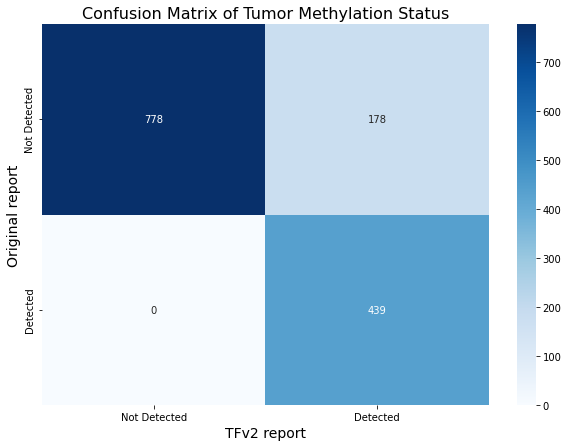

Cohen's Kappa: 0.73


In [12]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
map_status = {"Detected": 1, "Not Detected": 0}

# Map the 'Tumor_methylation_status' in both dataframes
df_sow176_2['Tumor_methylation_status_mapped'] = df_sow176_2['Tumor_methylation_status'].map(map_status)
df_sow176_final['Tumor_methylation_status_mapped'] = df_sow176_final['Tumor_methylation_status'].map(map_status)

# Merge the dataframes on GHSampleID to ensure matching entries
merged_df = pd.merge(df_sow176_2[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     df_sow176_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Filter out rows with NaN in either of the mapped status columns
valid_indices = merged_df['Tumor_methylation_status_mapped_2'].notna() & merged_df['Tumor_methylation_status_mapped_final'].notna()
y_true = merged_df[valid_indices]['Tumor_methylation_status_mapped_2'].values
y_pred = merged_df[valid_indices]['Tumor_methylation_status_mapped_final'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Original report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


## Check flipped positive calls

In [13]:
# Check the distribution of Visit_name for the flipped positive calls
df_visit = pd.merge(df_sow176_2[['GHSampleID', 'Tumor_methylation_status_mapped', 'Visit_name']],
                     df_sow176_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Create a mask for the specific case where status flips from Not Detected to Detected
mask = (df_visit['Tumor_methylation_status_mapped_2'] == 0) & (df_visit['Tumor_methylation_status_mapped_final'] == 1)
flipped_positive_samples = df_visit[mask]

# Get the MB score on positive flipped sampels
flipped_positive_samples_sample_ids = flipped_positive_samples['GHSampleID'].unique()

# Filter df_kyle_interest to find rows where run_sample_id is not in merged_sample_ids
df_flipped_pos = df_sow176_updated[df_sow176_updated['GHSampleID'].isin(flipped_positive_samples_sample_ids)]

df_flipped_pos.Visit_name.value_counts()

C3D1    52
C7D1    48
C1D1    45
C9D1    33
Name: Visit_name, dtype: int64

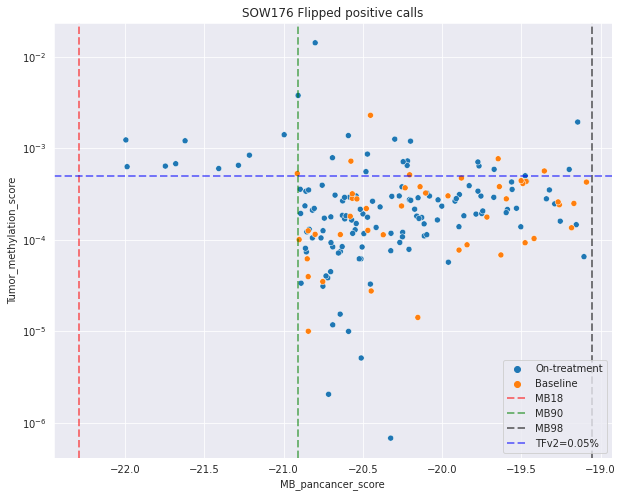

In [16]:
# Plot the distribution

df_flipped_pos['Treatment'] = np.where(
    (df_flipped_pos['Visit_name'] == 'C1D1'),
    'Baseline',
    'On-treatment'
)
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_flipped_pos, x='MB_pancancer_score', y='Tumor_methylation_score', 
                hue='Treatment')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684; MB98: -19.0509)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')
plt.axvline(x=-19.0509, color='black', linestyle='--', linewidth=2, alpha=0.5, label='MB98')


# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW176 Flipped positive calls')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')



In [33]:
df_flipped_pos_bottom_right = df_flipped_pos[(df_flipped_pos['MB_pancancer_score'] >= -22.289441) & (df_flipped_pos['pred_frac_force'] <= 0.0005)]
df_flipped_pos_bottom_right.Treatment.value_counts()

On-treatment    107
Baseline         39
Name: Treatment, dtype: int64

In [34]:
df_flipped_pos.Treatment.value_counts()

On-treatment    133
Baseline         45
Name: Treatment, dtype: int64

In [21]:
df_sow176_2['Treatment'] = np.where(
    (df_sow176_2['Visit_name'] == 'C1D1'),
    'Baseline',
    'On-treatment'
)

df_sow176_updated.Treatment.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Treatment'

In [22]:
df_sow176_updated_pos = df_sow176_updated[df_sow176_updated['Tumor_methylation_status'] == 'Detected']

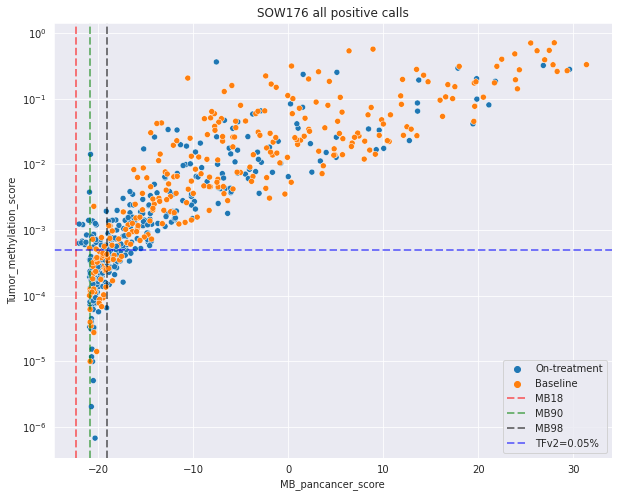

In [23]:
# Plot the distribution of all positive calls on this TFv2 update

df_sow176_updated_pos['Treatment'] = np.where(
    (df_sow176_updated_pos['Visit_name'] == 'C1D1'),
    'Baseline',
    'On-treatment'
)

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated_pos, x='MB_pancancer_score', y='Tumor_methylation_score', 
                hue='Treatment')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684; MB98: -19.0509)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')
plt.axvline(x=-19.0509, color='black', linestyle='--', linewidth=2, alpha=0.5, label='MB98')

# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW176 all positive calls')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')



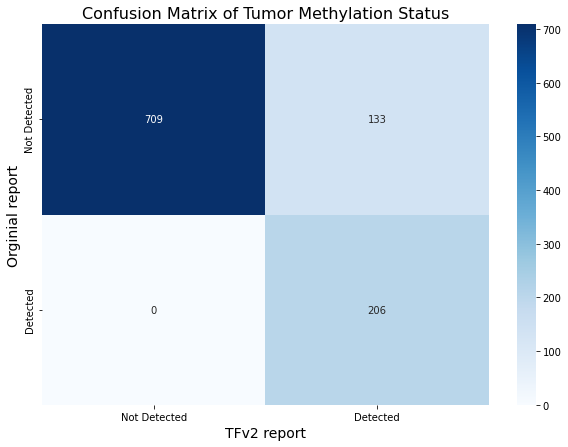

Cohen's Kappa: 0.68


In [104]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow176_monitoring_all['Tumor_methylation_status_mapped'] = df_sow176_monitoring_all['Tumor_methylation_status'].map(map_status)
df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'] = df_sow176_monitoring_final_all['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow176_monitoring_all['Tumor_methylation_status_mapped'].notna() & df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'].notna()
y_true = df_sow176_monitoring_all[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow176_monitoring_final_all[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [108]:
# Create a mask for the specific case
mask = (df_sow176_monitoring_all['Tumor_methylation_status_mapped'] == 0) & (df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow176_monitoring_final_all[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C3D1    52
C7D1    48
C9D1    33
Name: Visit_name, dtype: int64


In [170]:
df_sow176_monitoring_final_all.Visit_name.value_counts()

C9D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

In [106]:
# Remove duplication for infinity final
df_sow176_infinity_dedup = df_sow176_ori_1.drop_duplicates(subset = "GHSampleID")
df_sow176_infinity_final_dedup = df_sow176_infinity_final_all.drop_duplicates(subset = "GHSampleID")

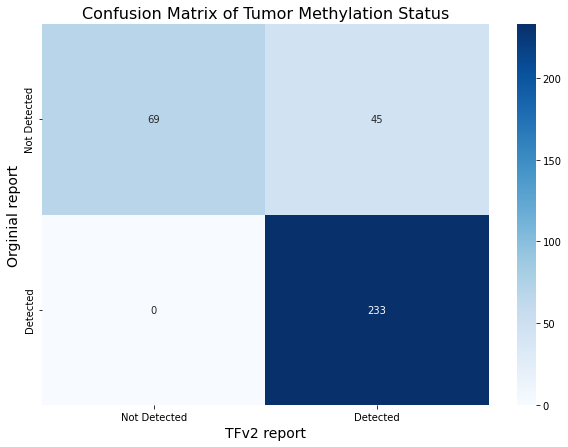

Cohen's Kappa: 0.67


In [107]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow176_infinity_dedup['Tumor_methylation_status_mapped'] = df_sow176_infinity_dedup['Tumor_methylation_status'].map(map_status)
df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'] = df_sow176_infinity_final_dedup['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow176_infinity_dedup['Tumor_methylation_status_mapped'].notna() & df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'].notna()
y_true = df_sow176_infinity_dedup[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow176_infinity_final_dedup[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [109]:
# Create a mask for the specific case
mask = (df_sow176_infinity_dedup['Tumor_methylation_status_mapped'] == 0) & (df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow176_infinity_final_dedup[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C1D1    45
Name: Visit_name, dtype: int64


In [72]:
df_sow176_final.Visit_name.value_counts()

C1D1    352
C9D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

In [172]:
df_sow176_2.Visit_name.value_counts()

C9D1    352
C1D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

# SOW181 TFv2 update

## Data preocessing

In [110]:
# Readin cummulative reports 

# SOW need to check the different versions of the delivered report
# Not able to retrieve two files together as a cumulative report using mr_pipeline.py
df_sow181_1_ori = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20240801_AstraZeneca_SOW181_12Samples_InfinityReport.csv", header = 1) 
df_sow181_2_ori = pd.read_csv(f"{work_dir}/Methyl_suppression_updated_batches_by_Evan/SOW181/20240812_AstraZeneca_SOW181_Monitoring_58Samples_Reveal_InfinityReport.csv", header = 0) 

# Concatenate the dataframes
# Important note !!!!! The data structure of df_sow181_1_ori, df_sow181_2_ori are different. The concatnation is not perfect but it's fine as we handel different reports separately later.

df_sow181_all = pd.concat([df_sow181_1_ori, df_sow181_2_ori], ignore_index=True)

print("Total sample size of SOW181 Infinity cumulative batches is " + str(df_sow181_all.shape[0]) + "\n") 
print("Total unique sample size of SOW181 Infinity cumulative batches is " + str(df_sow181_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW181 Infinity cumulative batches is " + str(df_sow181_all.Patient_ID.nunique()) + "\n")

df_sow181_all.head()

Total sample size of SOW181 Infinity cumulative batches is 747

Total unique sample size of SOW181 Infinity cumulative batches is 70

Total unique patient sample size of SOW181 Infinity cumulative batches is 12



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.0,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,EGFR,7,55249072.0,20,T790T,G>A,c.2370G>A,NM_005228.5,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs376452156,NaN,NaN,NaN,NaN,833.0,6.0,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,RECQL4,8,145739583.0,11,R623H,C>T,c.1868G>A,NM_004260.4,49.32,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs201734382,NaN,NaN,NaN,NaN,800.0,6.0,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KMT2B,19,36211292.0,3,Q348P,A>C,c.1043A>C,NM_014727.3,48.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs182258483,NaN,NaN,NaN,NaN,860.0,6.0,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CDC7,1,91973831.0,4,S71C,C>G,c.212C>G,NM_001134419.2,47.52,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs201145139,NaN,NaN,NaN,NaN,493.0,6.0,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN


In [111]:
# Remove duplication
df_sow181_dedup = df_sow181_all.drop_duplicates(subset = "GHSampleID")
df_sow181_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
17,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.026751,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
100,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.010531,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
137,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.128908,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
188,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.116207,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN


In [112]:
# Pull "runid" from ghdb
df_sow181_1 = df_sow181_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow181_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow181_1 = df_sow181_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow181_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.026751,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.010531,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.128908,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.116207,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC


In [113]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            primary_fc_dir = folders[0]
            # Check if there is a 'sirius' folder under the primary fc_dir. This is for Sirius 1.5 folder structure change.
            if os.path.exists(os.path.join(primary_fc_dir, "sirius")):
                primary_fc_dir = os.path.join(primary_fc_dir, "sirius")
            df.loc[index, 'fc_dir'] = primary_fc_dir
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow181_2, df_no_found = add_fc_dir_column(df_sow181_1)

print("Total sample size of SOW181 Infinity cumulative batches with fc_dir is " + str(df_sow181_2.shape[0]) + "\n") 
print("Total sample size of SOW181 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow181_2.head()



Total sample size of SOW181 Infinity cumulative batches with fc_dir is 70

Total sample size of SOW181 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.026751,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.010531,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.128908,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.116207,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925


## Generate Pancancer S3 MB caller outputs for this SOW
#### Notes:
    1. No cancer type provided
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [8]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW181_jobs"
    output_dir = f"{workdir}/MB_module_SOW181_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=60gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=01:00:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [9]:
df_sow181_2.shape

(70, 58)

In [9]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow181_2, 
                      f"{work_dir}")

Submitted batch job 87129927
Submitted batch job 87129928
Submitted batch job 87129929
Submitted batch job 87129931
Submitted batch job 87129932
Submitted batch job 87129934
Submitted batch job 87129935
Submitted batch job 87129936
Submitted batch job 87129937
Submitted batch job 87129938
Submitted batch job 87129939
Submitted batch job 87129940


In [114]:
# Retrieve MB S3 Pancancer caller score

df_sow181_3 = df_sow181_2.copy()

df_sow181_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW181_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow181_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow181_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow181_3.loc[problematic_rows]

print("Total sample size of SOW181 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow181_3.head()


Total sample size of SOW181 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,10.505035
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.026751,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,1.014980
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.010531,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,7.662465
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.128908,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,25.075645
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.116207,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,19.155684


In [40]:
df_problematic.fc_dir.value_counts()

/ghsfa/ivd/flowcentral/240804_A02056_0198_AHJNTKDSXC                                                        30
/ghsfa/ivd/flowcentral/240804_A02056_0199_BHJMVKDSXC                                                        20
/ghsfa/ivd/flowcentral/240805_A00274_1063_AHJN3CDSXC.09fa4552-9491-488f-ae5e-f3ee587c77a2.20240806203545     8
Name: fc_dir, dtype: int64

In [7]:
# # Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

# def run_bip_epigenomics_module_wrapper_sirius1_5_slurm(sample_meta_df, workdir):
#     module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
#     # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
#     parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


#     jobs_dir = f"{workdir}/MB_module_SOW181_jobs"
#     output_dir = f"{workdir}/MB_module_SOW181_output"

#     # Check and create directories if not exists
#     if not os.path.exists(jobs_dir):
#         os.makedirs(jobs_dir)

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     for _, row in sample_meta_df.iterrows():
#         run_sample_id = row["GHSampleID"]
#         fc_dir = row["fc_dir"]

#         # Check if there is a 'sirius' folder under the fc_dir. This is for Sirius 1.5 update
#         if os.path.exists(os.path.join(fc_dir, "sirius")):
#             fc_dir = os.path.join(fc_dir, "sirius")

#         mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
#         bip_config_json_file = f"{fc_dir}/bip_config.json"
        
#         if not os.path.exists(mbd_hyper_molecules):
#             continue

#         # Make a folder for each run_sample_id
#         output_sample_dir = f"{output_dir}/{run_sample_id}"

#         if not os.path.exists(output_sample_dir):
#             os.makedirs(output_sample_dir)

#         # Copy the bip_config.json for each sample from BIP output. This is essential for module running
#         # (samples in the same batch shared the same bip_config.json)
#         os.system(f"cp {bip_config_json_file} {output_sample_dir}")

#         job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
#         shebang_content = (f"#!/bin/bash\n"
#                            f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
#                            f"#SBATCH --nodes=1\n"
#                            f"#SBATCH --ntasks=1\n"
#                            f"#SBATCH --cpus-per-task=1\n"
#                            f"#SBATCH --mem=60gb\n"
#                            f"#SBATCH --partition=dev\n"
#                            f"#SBATCH --time=01:00:00\n"
#                            f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
#         with open(job_file, "w") as job_output:
#             job_output.write(shebang_content)
#             job_output.write(f"{module_dir}/module_entry msre_caller " + 
#                              f"--in-hyper-molecules {mbd_hyper_molecules} " + 
#                              f"--sample-id {run_sample_id} " + 
#                              f"--output-dir {output_sample_dir}/ " +
#                              f"--parameter-set {parameter_set_yaml} " + 
#                              f"--threads 16 " + 
#                              f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
#                              f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
#             # print(job_output)    
#         os.system(f"sbatch {job_file}")


In [ ]:
# #run the function to generate all the MB S3 caller ouputs for this sow  
# run_bip_epigenomics_module_wrapper_sirius1_5_slurm(df_problematic, 
#                       f"{work_dir}")

In [32]:
# # Retrieve MB S3 Pancancer caller score

# df_sow181_3 = df_sow181_2.copy()

# df_sow181_3["MB_pancancer_score"] = np.nan

# mb_caller_result_folder = f"{work_dir}/MB_module_SOW181_output"
# problematic_rows = []  # List to store indices of problematic rows

# for index, crc_row in df_sow181_3.iterrows():
#     run_sample_id = crc_row["GHSampleID"]
#     msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

#     try:
#         msre_df = pd.read_table(msre_mr_file)

#         if not msre_df.empty:
#             df_sow181_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

#         else:
#             # Add the index to the list if msre_df is empty
#             problematic_rows.append(index) 
            
#     except Exception as e:
#         # Add the index to the list if there is any other exception
#         problematic_rows.append(index)  
#         print(f"Error processing file {msre_mr_file}: {str(e)}")

# # Create a DataFrame with the indices of the problematic rows
# df_problematic = df_sow181_3.loc[problematic_rows]

# print("Total sample size of SOW181 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# # Returning the DataFrame with problematic rows
# df_sow181_3.head()


Total sample size of SOW181 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,10.505035
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.026751,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,1.014980
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.010531,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,7.662465
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.128908,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,25.075645
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.116207,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,19.155684


## Generate the epiTFv2 gamma score results

In [430]:
# Temporary solution for TFv2gamma score generation
df_sow181_3 = df_sow181_3[df_sow181_3['Sample_status'] != "FAIL"]
df_sow181_3.shape

# Save the data
df_sow181_3.to_csv(f"{work_dir}/df_sow181_3.csv", index = False)

In [83]:
# Step 1: save the input csv file
df_sow181_3 = pd.read_csv(f"{work_dir}/df_sow181_3.csv", header = 0)
df_sow181_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW181_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [12]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow181_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow181.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [13]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow181.sh")

Submitted batch job 87690037


0

In [115]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow181_4 = df_sow181_3[df_sow181_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow181_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW181_output"

for index, row in df_sow181_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow181_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW181 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow181_5 = df_sow181_4.copy()
df_sow181_5.head()

Total sample size of SOW181 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.017197,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,10.505035,0.015401
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.026751,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,1.014980,0.565043
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.010531,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,7.662465,0.029624
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.128908,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,25.075645,0.283705
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.116207,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,19.155684,0.134964


### For checking troubleshooting purposes on TFv2gamma


In [71]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow181_4 = df_sow181_3[df_sow181_3["GHSampleID"] == "B00727778"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow181_4.to_csv(f"{work_dir}/df_sow181_4.csv", index = False)
df_sow181_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
12,D9720C00001,E0301015_M4-C1D15_1,A1080502,B00727778,E0301015,M4-C1D15,1,SUCCESS,NaN,SNV,NaN,RECQL4,8,145738310.0,15.0,G892E,C>T,c.2675G>A,NM_004260.4,53.08,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1461172672,NaN,NaN,NaN,NaN,3802.0,10.76,NaN,NaN,Detected,0.019198,7.56,Low,Not Detected,239.44,2.0,0.0,04/15/2024,09/26/2022,08/12/2024,NaN,Not Applicable,Not Applicable,240804_A02056_0199_BHJMVKDSXC,/ghsfa/ivd/flowcentral/240804_A02056_0199_BHJMVKDSXC,7.954244


In [72]:
print(df_sow181_4['fc_dir'])


12    /ghsfa/ivd/flowcentral/240804_A02056_0199_BHJMVKDSXC
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [116]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684
df_sow181_updated = update_tumor_methylation_status(df_sow181_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow181_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,10.505035,0.015401
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.565043,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,1.014980,0.565043
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.029624,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,7.662465,0.029624
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.283705,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,25.075645,0.283705
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.134964,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240718_A00441_1046_BHJ5J2DSXC,/ghsfa/ivd/flowcentral/240718_A00441_1046_BHJ5J2DSXC.c209baca-3927-4b28-a484-6ce740aee19b.20240720060925,19.155684,0.134964


In [117]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow181_5_sub = df_sow181_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow181_5_sub_dedup = df_sow181_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW181 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow181_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow181_all_dedup = df_sow181_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW181 Infinity cumulative batches is " + str(df_sow181_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow181_all_dedup.Sample_status.value_counts()


Total sample size of SOW181 Infinity cumulative batches with updated MB score and TFv2gamma is 70

Total sample size of original SOW181 Infinity cumulative batches is 70



SUCCESS    70
Name: Sample_status, dtype: int64

### Handel Reveal and Infinity reports separately

In [118]:
df_sow181_1_ori = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20240801_AstraZeneca_SOW181_12Samples_InfinityReport.csv", header = 1) 
df_sow181_2_ori = pd.read_csv(f"{work_dir}/Methyl_suppression_updated_batches_by_Evan/SOW181/20240812_AstraZeneca_SOW181_Monitoring_58Samples_Reveal_InfinityReport.csv", header = 0) 


In [119]:
df_sow181_2_ori.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,D9720C00001,E0301015_M4-C1D15_1,A1080502,B00727778,E0301015,NaN,NaN,M4-C1D15,SUCCESS,NaN,Detected,Detected,0.019198,239.440,2.0,0.0,04/15/2024,09/26/2022,08/12/2024
1,D9720C00001,E0301015_M4-C1D8_1,A1080476,B00727800,E0301015,NaN,NaN,M4-C1D8,SUCCESS,NaN,Detected,Detected,0.018104,525.600,2.0,0.0,04/15/2024,09/19/2022,08/12/2024
2,D9720C00001,E0301015_M4-C2D1_1,A1080508,B00727815,E0301015,NaN,NaN,M4-C2D1,SUCCESS,NaN,Detected,Detected,0.154152,154.760,2.0,0.0,04/15/2024,10/03/2022,08/12/2024
3,D9720C00001,E0301015_M4-C3D1_1,A1080487,B00727829,E0301015,NaN,NaN,M4-C3D1,SUCCESS,NaN,Detected,Detected,0.014217,127.896,2.0,0.0,04/15/2024,10/24/2022,08/12/2024
4,D9720C00001,E0301020_M4-C1D1_1,A1080473,B00727801,E0301020,NaN,NaN,M4-C1D1,SUCCESS,NaN,Detected,Detected,0.030218,184.544,0.5,0.0,04/15/2024,03/08/2023,08/12/2024


In [120]:
# For Infinity report

df_merged = df_sow181_1_ori.merge(df_sow181_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow181_infinity_final_all = df_merged[df_sow181_1_ori.columns]

# Save the data
df_sow181_infinity_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW181_12Samples_InfinityReport.csv", index = False)

df_sow181_infinity_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.0,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable
1,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1,SUCCESS,NaN,SNV,NaN,EGFR,7,55249072.0,20,T790T,G>A,c.2370G>A,NM_005228.5,51.39,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs376452156,NaN,NaN,NaN,NaN,833.0,6.0,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable
2,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1,SUCCESS,NaN,SNV,NaN,RECQL4,8,145739583.0,11,R623H,C>T,c.1868G>A,NM_004260.4,49.32,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs201734382,NaN,NaN,NaN,NaN,800.0,6.0,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable
3,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36211292.0,3,Q348P,A>C,c.1043A>C,NM_014727.3,48.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs182258483,NaN,NaN,NaN,NaN,860.0,6.0,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable
4,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1,SUCCESS,NaN,SNV,NaN,CDC7,1,91973831.0,4,S71C,C>G,c.212C>G,NM_001134419.2,47.52,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs201145139,NaN,NaN,NaN,NaN,493.0,6.0,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable


In [121]:
df_sow181_infinity_final_all.GHSampleID.nunique()

12

In [122]:
# For Reveal/monitoring batches

df_merged = df_sow181_2_ori.merge(df_sow181_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])
df_merged['ctDNA_detected'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow181_monitoring_final_all = df_merged[df_sow181_2_ori.columns]

# Save the data
df_sow181_monitoring_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW181_Monitoring_58Samples_TFv2_RevealInfinityReport.csv", index = False)

df_sow181_monitoring_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,D9720C00001,E0301015_M4-C1D15_1,A1080502,B00727778,E0301015,NaN,NaN,M4-C1D15,SUCCESS,NaN,Detected,Detected,0.034272,239.440,2.0,0.0,04/15/2024,09/26/2022,08/12/2024
1,D9720C00001,E0301015_M4-C1D8_1,A1080476,B00727800,E0301015,NaN,NaN,M4-C1D8,SUCCESS,NaN,Detected,Detected,0.031603,525.600,2.0,0.0,04/15/2024,09/19/2022,08/12/2024
2,D9720C00001,E0301015_M4-C2D1_1,A1080508,B00727815,E0301015,NaN,NaN,M4-C2D1,SUCCESS,NaN,Detected,Detected,0.284203,154.760,2.0,0.0,04/15/2024,10/03/2022,08/12/2024
3,D9720C00001,E0301015_M4-C3D1_1,A1080487,B00727829,E0301015,NaN,NaN,M4-C3D1,SUCCESS,NaN,Detected,Detected,0.023896,127.896,2.0,0.0,04/15/2024,10/24/2022,08/12/2024
4,D9720C00001,E0301020_M4-C1D1_1,A1080473,B00727801,E0301020,NaN,NaN,M4-C1D1,SUCCESS,NaN,Detected,Detected,0.5356,184.544,0.5,0.0,04/15/2024,03/08/2023,08/12/2024


In [123]:
df_sow181_monitoring_final_all.GHSampleID.nunique()

58

In [124]:
# For confusion table only

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow181_all_dedup.merge(df_sow181_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow181_final = df_merged[df_sow181_all_dedup.columns]

# Save the data
df_sow181_final.to_csv(f"{work_dir}/df_sow181_final.csv", index = False)

df_sow181_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9720C00001,E0301023_SCRN_1,A1080446,B00712213,E0301023,SCRN,1.0,SUCCESS,NaN,SNV,NaN,SETD2,3,47165228.0,3,L300L,G>A,c.898C>T,NM_014159.7,52.44,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.0,6.00,NaN,NaN,Detected,0.015401,2.84,Low,Not Detected,6.25,1.0,0.0,04/23/2024,06/27/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D9720C00001,E0301020_SCRN_1,A1080447,B00712215,E0301020,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TET2,4,106156953.0,3,Q618Q,A>G,c.1854A>G,NM_001127208.3,85.81,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs138665881,NaN,NaN,NaN,NaN,3642.0,72.10,NaN,NaN,Detected,0.565043,10.40,Low,Not Detected,106.87,1.0,0.0,04/23/2024,03/01/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D9720C00001,E7001032_SCRN_1,A1080448,B00712245,E7001032,SCRN,1.0,SUCCESS,NaN,SNV,NaN,TBX3,12,115112043.0,7,A566V,G>A,c.1697C>T,NM_016569.4,54.38,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57474990,rs372029833,NaN,NaN,NaN,NaN,1663.0,9.25,NaN,NaN,Detected,0.029624,11.34,Low,Not Detected,19.80,2.0,0.0,04/23/2024,11/11/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D9720C00001,E7001030_SCRN_1,A1080449,B00712247,E7001030,SCRN,1.0,SUCCESS,NaN,SNV,NaN,KNSTRN,15,40675176.0,1,T47R,C>G,c.140C>G,NM_033286.3,53.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199715714,NaN,NaN,NaN,NaN,1564.0,42.92,NaN,NaN,Detected,0.283705,5.67,Low,Not Detected,26.22,1.0,0.0,04/23/2024,10/07/2022,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D9720C00001,E6001029_SCRN_1,A1080450,B00712227,E6001029,SCRN,1.0,SUCCESS,NaN,SNV,NaN,CTNNA1,5,138147988.0,5,Q195Q,A>G,c.585A>G,NM_001903.5,57.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs747815829,NaN,NaN,NaN,NaN,482.0,15.78,NaN,NaN,Detected,0.134964,15.12,Low,Not Detected,13.26,1.0,0.0,04/23/2024,03/29/2023,08/01/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN


In [90]:
df_sow181_final_all.shape

(3361, 56)

In [91]:
df_sow181_final.shape

(70, 56)

In [13]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow181_infinity_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW181_12Samples_InfinityReport.csv")
df_sow181_monitoring_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW181_Monitoring_58Samples_TFv2_RevealInfinityReport.csv")

# Ad-hoc process
df_sow181_infinity_final_all_new = suppress_methylation_score_higher_than_1(df_sow181_infinity_final_all)
df_sow181_monitoring_final_all_new = suppress_methylation_score_higher_than_1(df_sow181_monitoring_final_all)

# Save the data
df_sow181_infinity_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW181_12Samples_InfinityReport.csv", index = False)
df_sow181_monitoring_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW181_Monitoring_58Samples_TFv2_RevealInfinityReport.csv", index = False)


Rows with scores > 1 before modification:
   GHSampleID  Tumor_methylation_score
54  B00729406                  1.04692

Rows after modification:
   GHSampleID  Tumor_methylation_score
54  B00729406                     0.99


## Data Visualization

### Confusion Matrix

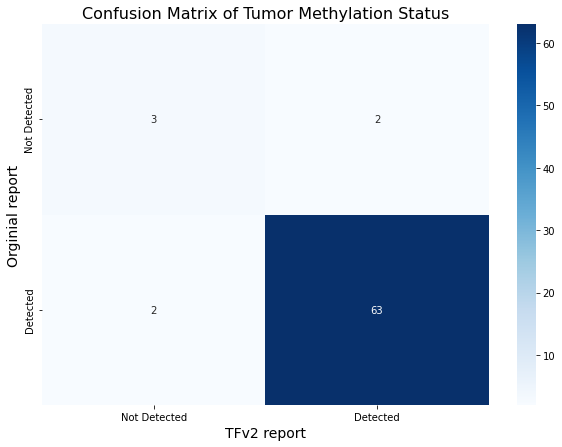

Cohen's Kappa: 0.57


In [125]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow181_2['Tumor_methylation_status_mapped'] = df_sow181_2['Tumor_methylation_status'].map(map_status)
df_sow181_final['Tumor_methylation_status_mapped'] = df_sow181_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow181_2['Tumor_methylation_status_mapped'].notna() & df_sow181_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow181_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow181_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [128]:
df_sow181_2.Sample_status.value_counts()

SUCCESS    70
Name: Sample_status, dtype: int64

In [129]:
# Create a mask for the specific case
mask = (df_sow181_2['Tumor_methylation_status_mapped'] == 0) & (df_sow181_final['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow181_final[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


M4-C2D1     1
M5-C2D15    1
Name: Visit_name, dtype: int64


# SOW182 TFv2 update (Lung)

## Data preocessing

In [93]:
# # Readin cummulative reports 

# # SOW need to check the different versions of the delivered report
# df_sow182_all = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20240116_AstraZeneca_SOW182_40Samples_InfinityReport.csv", header = 0) 

# print("Total sample size of SOW182 Infinity cumulative batches is " + str(df_sow182_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW182 Infinity cumulative batches is " + str(df_sow182_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW182 Infinity cumulative batches is " + str(df_sow182_all.Patient_ID.nunique()) + "\n")

# df_sow182_all.head()

Total sample size of SOW182 Infinity cumulative batches is 693

Total unique sample size of SOW182 Infinity cumulative batches is 40

Total unique patient sample size of SOW182 Infinity cumulative batches is 8



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,0.0,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,01/16/2024,Lung,Not Applicable,Not Applicable
1,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42794874.0,10.0,A652P,G>C,c.1954G>C,NM_015125.5,47.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs770323488,NaN,NaN,NaN,NaN,1903.0,0.0,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,01/16/2024,Lung,Not Applicable,Not Applicable
2,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,47.28,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,2179.0,0.0,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,01/16/2024,Lung,Not Applicable,Not Applicable
3,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,EMSY,11,76253389.0,18.0,A896G,C>G,c.2687C>G,NM_020193.5,47.22,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200985374,NaN,NaN,NaN,NaN,1839.0,0.0,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,01/16/2024,Lung,Not Applicable,Not Applicable
4,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36224008.0,28.0,P2186P,C>T,c.6558C>T,NM_014727.3,46.47,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs777573810,NaN,NaN,NaN,NaN,2109.0,0.0,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,01/16/2024,Lung,Not Applicable,Not Applicable


In [32]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

df_sow182_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW182_Infinity/AZN_SOW182_Infinity_01/20240613_AstraZeneca_SOW182_40Samples_TFV2_InfinityReport.csv", header = 0) 

print("Total sample size of SOW182 Infinity cumulative batches is " + str(df_sow182_all.shape[0]) + "\n") 
print("Total unique sample size of SOW182 Infinity cumulative batches is " + str(df_sow182_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW182 Infinity cumulative batches is " + str(df_sow182_all.Patient_ID.nunique()) + "\n")

df_sow182_all.head()

Total sample size of SOW182 Infinity cumulative batches is 1175

Total unique sample size of SOW182 Infinity cumulative batches is 40

Total unique patient sample size of SOW182 Infinity cumulative batches is 8



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
1,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42794874.0,10.0,A652P,G>C,c.1954G>C,NM_015125.5,47.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs770323488,NaN,NaN,NaN,NaN,1903.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
2,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,47.28,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,2179.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
3,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,EMSY,11,76253389.0,18.0,A896G,C>G,c.2687C>G,NM_020193.5,47.22,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200985374,NaN,NaN,NaN,NaN,1839.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
4,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36224008.0,28.0,P2186P,C>T,c.6558C>T,NM_014727.3,46.47,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs777573810,NaN,NaN,NaN,NaN,2109.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable


In [33]:
# Remove duplication
df_sow182_dedup = df_sow182_all.drop_duplicates(subset = "GHSampleID")
df_sow182_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
23,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
47,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
72,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
103,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable


In [34]:
df_sow182_dedup.Tumor_methylation_status.value_counts()

Detected        24
Not Detected    15
Name: Tumor_methylation_status, dtype: int64

In [4]:
df_sow182_dedup.Cancertype.value_counts()

Lung    40
Name: Cancertype, dtype: int64

In [5]:
# Pull "runid" from ghdb
df_sow182_1 = df_sow182_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow182_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow182_1 = df_sow182_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow182_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7


In [6]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow182_2, df_no_found = add_fc_dir_column(df_sow182_1)

print("Total sample size of SOW182 Infinity cumulative batches with fc_dir is " + str(df_sow182_2.shape[0]) + "\n") 
print("Total sample size of SOW182 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow182_2.head()



Total sample size of SOW182 Infinity cumulative batches with fc_dir is 40

Total sample size of SOW182 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7


## Generate S3 MB Lung caller outputs for this SOW
#### Notes:
    1. Cancer type is Lung
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [10]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW182_jobs"
    output_dir = f"{workdir}/MB_module_SOW182_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=40gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:50:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [11]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow182_2, 
                      f"{work_dir}")

Submitted batch job 87131187
Submitted batch job 87131188
Submitted batch job 87131190
Submitted batch job 87131193
Submitted batch job 87131195
Submitted batch job 87131196
Submitted batch job 87131197
Submitted batch job 87131198
Submitted batch job 87131199
Submitted batch job 87131200
Submitted batch job 87131201
Submitted batch job 87131202
Submitted batch job 87131203
Submitted batch job 87131204
Submitted batch job 87131205
Submitted batch job 87131207
Submitted batch job 87131208
Submitted batch job 87131210
Submitted batch job 87131211
Submitted batch job 87131212
Submitted batch job 87131213
Submitted batch job 87131214
Submitted batch job 87131215
Submitted batch job 87131216
Submitted batch job 87131217
Submitted batch job 87131218
Submitted batch job 87131219
Submitted batch job 87131220
Submitted batch job 87131221
Submitted batch job 87131222
Submitted batch job 87131223
Submitted batch job 87131224
Submitted batch job 87131225
Submitted batch job 87131226
Submitted batc

In [449]:
# Retrieve MB S3 Pancancer caller score

df_sow182_3 = df_sow182_2.copy()

df_sow182_3["MB_lung_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW182_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow182_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_lung_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow182_3.at[index, "MB_lung_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow182_3.loc[problematic_rows]

print("Total sample size of SOW182 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow182_3.head()


Total sample size of SOW182 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_lung_score
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-19.233337
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-18.905461
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-20.809207
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-15.621655
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-18.296193


## Generate Lung CpG model caller outputs for this SOW (by Shile 02/05/2025)
#### Notes from Shile: update the methylation lung caller with the latest CpG model, which I have generated data here with methyl score threshold at 0 (methyl score >0, tumor detected)


In [7]:
# Readin the data that Shile generated for Lung CpG model caller 
df_lung_cpg_model = pd.read_csv('/ghds/projects/pharma/projects/sirius_pharma/cohort_reports/20240112_AZ_SOW182/Lung_MB_update/SOW182_updated_lung_caller_adjusted_score_threshold0.csv')
df_lung_cpg_model.head()

,GHSampleID,Patient_ID,Customer_SampleID,Sample_status,mb_lung_methyl_score_adjusted
0,B00565545,MS_set5,MS_set 5_s1,SUCCESS,0.141481
1,B00565516,MS_set5,MS_set 5_s5,SUCCESS,1.197361
2,B00565526,MS_set5,MS_set 5_s6,SUCCESS,-0.492875
3,B00565518,MS_set5,MS_set 5_s7,SUCCESS,3.387913
4,B00565521,MS_set5,MS_set 5_s8,SUCCESS,1.961810


In [9]:
df_sow182_2.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7


In [13]:
# Retrieve Lung cpg model lung caller score
df_sow182_3 = df_sow182_2.copy()
df_sow182_3 = df_sow182_3.merge(df_lung_cpg_model[['GHSampleID', 'mb_lung_methyl_score_adjusted']], on = 'GHSampleID', how = 'left')

# Rename
df_sow182_3 = df_sow182_3.rename(columns={"mb_lung_methyl_score_adjusted": "MB_lung_score"})
df_sow182_3.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_lung_score
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,0.141481
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,1.197361
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-0.492875
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,3.387913
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,1.961810


## Generate the epiTFv2 gamma score results

In [450]:
# Temporary solution for TFv2gamma score generation
df_sow182_3 = df_sow182_3[df_sow182_3['Sample_status'] != "FAIL"]
df_sow182_3.shape

# Save the data
df_sow182_3.to_csv(f"{work_dir}/df_sow182_3.csv", index = False)

In [85]:
# Step 1: save the input csv file
df_sow182_3 = pd.read_csv(f"{work_dir}/df_sow182_3.csv", header = 0)
df_sow182_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW182_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [16]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow182_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow182.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [17]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow182.sh")

Submitted batch job 87133764


0

In [14]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow182_4 = df_sow182_3[df_sow182_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow182_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW182_output"

for index, row in df_sow182_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow182_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW182 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow182_5 = df_sow182_4.copy()
df_sow182_5.head()

Total sample size of SOW182 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_lung_score,pred_frac_force
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,0.141481,0.000021
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,1.197361,0.000094
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0.000000,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-0.492875,0.000008
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,3.387913,0.000672
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,1.961810,0.000243


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [ ]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run Lung caller cutoffs for the SOW: MB18: -22.421763; MB90: -20.941267
df_sow182_updated = update_tumor_methylation_status(df_sow182_5, 'MB_lung_score', -22.421763, -20.941267)

df_sow182_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_lung_score,pred_frac_force
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-19.233337,0.000021
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-18.905461,0.000094
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Detected,0.000008,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-20.809207,0.000008
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-15.621655,0.000672
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-18.296193,0.000243


In [15]:
# Optional step only for lung cpg model caller result update requested on 02/02/2025
def update_tumor_methylation_status_cpg_lung(df):
    # case1: Addressing calls where "MB_lung_score" > 0, then "Tumor_methylation_status" is "Detected", the update the "Tumor_methylation_score" 
    conditions_case1 = (df['MB_lung_score'] > 0)

    # case2: Addressing calls where "MB_lung_score" <= 0, then "Tumor_methylation_status" is "Not Detected", force the "Tumor_methylation_score" to 0
    conditions_case2 = (df['MB_lung_score'] <= 0)

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run Lung caller cutoffs for the SOW
df_sow182_updated = update_tumor_methylation_status_cpg_lung(df_sow182_5)

df_sow182_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_lung_score,pred_frac_force
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,0.141481,0.000021
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,1.197361,0.000094
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,-0.492875,0.000008
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,3.387913,0.000672
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable,231222_A01907_0196_BHMF2CDSX7,/ghsfa/ivd/flowcentral/231222_A01907_0196_BHMF2CDSX7,1.961810,0.000243


In [17]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow182_5_sub = df_sow182_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow182_5_sub_dedup = df_sow182_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW182 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow182_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow182_all_dedup = df_sow182_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW182 Infinity cumulative batches is " + str(df_sow182_5_sub_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow182_all_dedup.Sample_status.value_counts()


Total sample size of SOW182 Infinity cumulative batches with updated MB score and TFv2gamma is 39

Total sample size of original SOW182 Infinity cumulative batches is 39



SUCCESS    39
FAIL        1
Name: Sample_status, dtype: int64

In [18]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow182_all_dedup.merge(df_sow182_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow182_final = df_merged[df_sow182_all_dedup.columns]

# # Save the data
# df_sow182_final.to_csv(f"{work_dir}/df_sow182_final.csv", index = False)

df_sow182_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
1,PROTEUS,MS_set 5_s5,A0921480,B00565516,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,WWP1,8,87470253.0,22.0,Q833R,A>G,c.2498A>G,NM_007013.4,51.11,splice_region_variant,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.0,2.51,NaN,NaN,Detected,0.000094,5.74,Low,Not Detected,10.712,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
2,PROTEUS,MS_set 5_s6,A0921485,B00565526,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,TERT,5,1260613.0,12.0,C982C,A>G,c.2946T>C,NM_198253.3,48.55,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57241735,rs201689770,Likely_benign,239631.0,NaN,NaN,2541.0,2.71,NaN,NaN,Not Detected,0,6.62,Low,Not Detected,14.560,4.0,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
3,PROTEUS,MS_set 5_s7,A0921483,B00565518,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,49.40,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1724.0,2.83,NaN,NaN,Detected,0.000672,10.97,Low,Not Detected,12.220,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
4,PROTEUS,MS_set 5_s8,A0921488,B00565521,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,48.57,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,1987.0,3.01,NaN,NaN,Detected,0.000243,6.68,Low,Not Detected,12.584,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable


In [19]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow182_all.merge(df_sow182_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow182_final_all = df_merged[df_sow182_all.columns]

# Save the data
# df_sow182_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW182_40Samples_TFv2_InfinityReport.csv", index = False)
df_sow182_final_all.to_csv(f"{work_dir}/20250205_AstraZeneca_SOW182_40Samples_TFv2_InfinityReport.csv", index = False)

df_sow182_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,NF1,17,29657435.0,39.0,I1911V,A>G,c.5731A>G,NM_001042492.3,48.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs146523293,Uncertain_significance,184697.0,NaN,NaN,1632.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
1,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42794874.0,10.0,A652P,G>C,c.1954G>C,NM_015125.5,47.96,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs770323488,NaN,NaN,NaN,NaN,1903.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
2,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,CIC,19,42778612.0,2.0,F893L,T>C,c.2677T>C,NM_001304815.1,47.28,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs767308169,NaN,NaN,NaN,NaN,2179.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
3,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,EMSY,11,76253389.0,18.0,A896G,C>G,c.2687C>G,NM_020193.5,47.22,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200985374,NaN,NaN,NaN,NaN,1839.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable
4,PROTEUS,MS_set 5_s1,A0921471,B00565545,MS_set5,NaN,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36224008.0,28.0,P2186P,C>T,c.6558C>T,NM_014727.3,46.47,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs777573810,NaN,NaN,NaN,NaN,2109.0,2.63,NaN,NaN,Detected,0.000021,5.69,Low,Not Detected,12.844,3.5,0.0,11/30/2023,05/14/2021,06/11/2024,Lung,Not Applicable,Not Applicable


In [457]:
df_sow182_final_all.shape

(1175, 56)

In [458]:
df_sow182_all.shape

(1175, 56)

In [23]:
df_sow182_final_all.GHSampleID.nunique()

40

In [92]:
df_sow182_final.shape

(40, 56)

In [24]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
# df_sow182_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW182_40Samples_TFv2_InfinityReport.csv")
df_sow182_final_all = pd.read_csv(f"{work_dir}/20250205_AstraZeneca_SOW182_40Samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow182_final_all_new = suppress_methylation_score_higher_than_1(df_sow182_final_all)

# Save the data
# df_sow182_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW182_40Samples_TFv2_InfinityReport.csv", index = False)
df_sow182_final_all_new.to_csv(f"{work_dir}/20250205_AstraZeneca_SOW182_40Samples_TFv2_InfinityReport.csv", index = False)

In [30]:
# Compare the two updates detection condition

# 20241104 update results
df_sow182_final_old = pd.read_csv(f"{work_dir}/df_sow182_final.csv")
print(df_sow182_final_old.Tumor_methylation_status.value_counts())

# 202502025 update results
df_sow182_final.Tumor_methylation_status.value_counts()

Detected        32
Not Detected     7
Name: Tumor_methylation_status, dtype: int64


Detected        28
Not Detected    11
Name: Tumor_methylation_status, dtype: int64

## Data Visualization

### Confusion Matrix

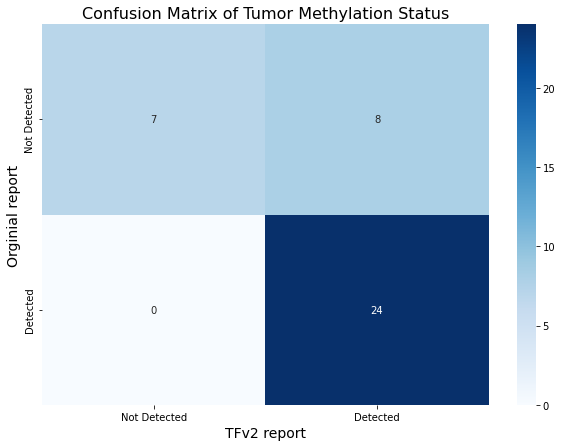

Cohen's Kappa: 0.52


In [460]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow182_2['Tumor_methylation_status_mapped'] = df_sow182_2['Tumor_methylation_status'].map(map_status)
df_sow182_final['Tumor_methylation_status_mapped'] = df_sow182_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow182_2['Tumor_methylation_status_mapped'].notna() & df_sow182_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow182_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow182_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


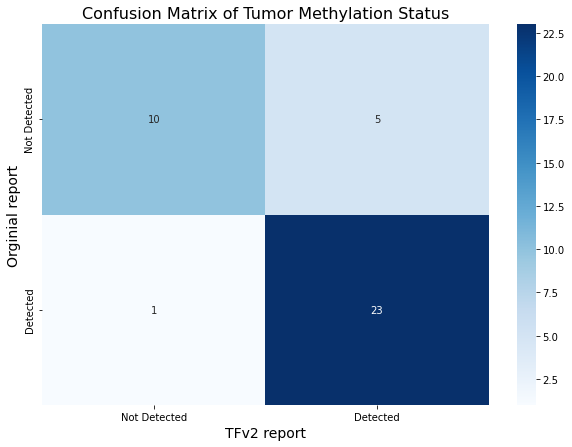

Cohen's Kappa: 0.66


In [27]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow182_2['Tumor_methylation_status_mapped'] = df_sow182_2['Tumor_methylation_status'].map(map_status)
df_sow182_final['Tumor_methylation_status_mapped'] = df_sow182_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow182_2['Tumor_methylation_status_mapped'].notna() & df_sow182_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow182_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow182_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# SOW187 TFv2 update (compatible for Sirius 1.5 BIP output)
##### This section SOW187 is the latest template to use for the future batch update

## Data preocessing

In [211]:
# # Readin cummulative reports 

# # SOW need to check the different versions of the delivered report
# df_sow187_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187_Infinity/AZN_SOW187_Infinity_03/molecular_response/AZN_SOW187_Infinity_cumulative_report.csv", header = 1) 

# print("Total sample size of SOW187 Infinity cumulative batches is " + str(df_sow187_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW187 Infinity cumulative batches is " + str(df_sow187_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW187 Infinity cumulative batches is " + str(df_sow187_all.Patient_ID.nunique()) + "\n")

# df_sow187_all.head()

Total sample size of SOW187 Infinity cumulative batches is 18316

Total unique sample size of SOW187 Infinity cumulative batches is 364

Total unique patient sample size of SOW187 Infinity cumulative batches is 102



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9268C00001,6219533356,A0988363,B00673868,E0503001,EOT,1,SUCCESS,Methylation Suppression Warning; Methylation Bias Warning,SNV,NaN,KMT2A,11,118392784,36,R3936Q,G>A,c.11807G>A,NM_005933.4,68.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105254711,NaN,NaN,NaN,NaN,NaN,4054,36.8,NaN,NaN,18.9,Low,Not Detected,44.252,3.5,0,3/4/24,12/5/22,6/7/24,BREAST,Not Applicable,Not Applicable


In [24]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive

# 3 Infinity batches
df_sow187_ori_1 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187_Infinity/AZN_SOW187_Infinity_01/tb/20240620_AstraZeneca_SOW187_227Samples_TFv2_InfinityReport.csv", header = 0) 
df_sow187_ori_2 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187_Infinity/AZN_SOW187_Infinity_02/tb/20240703_AstraZeneca_SOW187_23Samples_TFv2_InfinityReport.csv", header = 0) 
df_sow187_ori_3 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187_Infinity/AZN_SOW187_Infinity_03/tb/20240812_AstraZeneca_SOW187_90Samples_TFv2_InfinityReport.csv", header = 0) 
# 2 Monitoring batches
df_sow187_ori_4 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187Monitoring_Infinity/AZN_SOW187Monitoring_Infinity_01/tb/20240620_AstraZeneca_SOW187_Monitoring_236Samples_TFv2_RevealInfinityReport.csv", header = 0) 
df_sow187_ori_5 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187Monitoring_Infinity/AZN_SOW187Monitoring_Infinity_02/tb/20240709_AstraZeneca_SOW187_Monitoring_23Samples_TFv2_RevealInfinityReport.csv", header = 0) 
# 2 buffy batches
df_sow187_ori_6 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187Buffy_Infinity/AZN_SOW187Buffy_Infinity_01/tb/20240703_AstraZeneca_SOW187_Buffy_70Samples_500gene_InfinityReport.csv", header = 0) 
df_sow187_ori_7 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW187Buffy_Infinity/AZN_SOW187Buffy_Infinity_02/tb/20240709_AstraZeneca_SOW187_Buffy_9Samples_500gene_InfinityReport.csv", header = 0) 


# Concatenate the dataframes
# Important note !!!!! The data structure of these dataframes are different. The concatnation is not perfect but it's fine as we handel different reports separately later.
df_sow187_all = pd.concat([df_sow187_ori_1, df_sow187_ori_2, df_sow187_ori_3, df_sow187_ori_4, df_sow187_ori_5, df_sow187_ori_6, df_sow187_ori_7], ignore_index=True)

print("Total sample size of SOW187 Infinity cumulative batches is " + str(df_sow187_all.shape[0]) + "\n") 
print("Total unique sample size of SOW187 Infinity cumulative batches is " + str(df_sow187_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW187 Infinity cumulative batches is " + str(df_sow187_all.Patient_ID.nunique()) + "\n")

df_sow187_all.head()

Total sample size of SOW187 Infinity cumulative batches is 19234

Total unique sample size of SOW187 Infinity cumulative batches is 678

Total unique patient sample size of SOW187 Infinity cumulative batches is 101



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,KDM5B,1,202702576.0,24.0,Y1324H,A>G,c.3970T>C,NM_001314042.1,51.91,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs137981335,NaN,NaN,NaN,NaN,1747.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,ARID1B,6,157150450.0,2.0,P544P,G>A,c.1632G>A,NM_017519.3,51.21,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142939952,Likely_benign,579262.0,NaN,NaN,1877.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CMTM4,16,66656017.0,4.0,R191C,G>A,c.571C>T,NM_181521.3,50.61,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374010185,NaN,NaN,NaN,NaN,1556.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SLC34A2,4,25678250.0,13.0,A651G,C>G,c.1952C>G,NM_006424.3,50.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs548315834,NaN,NaN,NaN,NaN,1625.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,MDC1,6,30680595.0,5.0,G375V,C>A,c.1124G>T,NM_014641.3,49.08,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200239032,NaN,NaN,NaN,NaN,1707.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN


In [90]:
df_sow187_ori_1.Tumor_methylation_status.isnull().size

11101

In [25]:
# Remove duplication
df_sow187_dedup = df_sow187_all.drop_duplicates(subset = "GHSampleID")
df_sow187_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,KDM5B,1,202702576.0,24.0,Y1324H,A>G,c.3970T>C,NM_001314042.1,51.91,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs137981335,NaN,NaN,NaN,NaN,1747.0,1.70,NaN,NaN,Not Detected,0.000000,5.59,Low,Not Detected,9.620,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
26,D926UC00001,6521960617,A0992203,B00670675,E1007006,SCREEN,1.0,SUCCESS,Methylation Bias Warning,SNV,NaN,ALOX12B,17,7978989.0,12.0,A526A,G>A,c.1578C>T,NM_001139.3,53.96,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200507128,NaN,NaN,NaN,NaN,762.0,0.83,NaN,NaN,Not Detected,0.000000,4.73,Low,Not Detected,9.360,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
50,D926UC00001,6521960618,A0992192,B00670684,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,61.20,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,1141.0,36.61,NaN,NaN,Detected,0.573687,12.29,Low,Not Detected,74.880,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
194,D926UC00001,6521960620,A0992210,B00670685,E1007008,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FANCA,16,89816239.0,32.0,H1046H,G>A,c.3138C>T,NM_000135.4,52.99,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV104619833,rs150884376,Conflicting_interpretations_of_pathogenicity,336739.0,NaN,NaN,3705.0,69.15,NaN,NaN,Detected,0.002179,11.34,Low,Not Detected,25.896,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
245,D926UC00001,6521683317,A0992194,B00670694,E1011002,C1D1,1.0,SUCCESS,Methylation Bias Warning,SNV,NaN,CDK12,17,37673691.0,10.0,NaN,A>T,c.2847-2A>T,NM_016507.4,57.19,splice_acceptor_variant,somatic,splice_acceptor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deleterious_trans,biallelic,4457.0,55.15,NaN,NaN,Detected,0.784087,11.34,Low,Not Detected,37.232,1.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN


In [62]:
# # Pull "runid" from ghdb
# df_sow187_1 = df_sow187_dedup.copy()

# # Define the IDs you want to query for
# ids = tuple(df_sow187_1['GHSampleID'].unique())

# # Generate the SQL query string
# query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# # Get the dataframe with "runid"
# sample_df = functions.run_sql_query(query)
# sample_df.head()

# # Merge "runid" 
# sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
# df_sow187_1 = df_sow187_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
# df_sow187_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,D926UC00001,6802077988,A1088647,B00723840,E4306001,SCREEN,1,SUCCESS,NaN,SNV,NaN,FCGR2A,1,161479860.0,4,V205V,C>T,c.615C>T,NM_001136219.3,59.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs55722329,NaN,NaN,NaN,NaN,5114.0,26.170,NaN,NaN,Detected,0.022170,84.32,High,Detected,93.44,2.0,0.0,06/26/2024,02/22/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0435_AHJNM2DSXC
1,D926UC00001,6802077987,A1088648,B00723856,E4306003,SCREEN,1,SUCCESS,NaN,SNV,NaN,BLM,15,91304388.0,7,S595S,A>T,c.1785A>T,NM_000057.4,55.59,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs79871543,NaN,NaN,NaN,NaN,649.0,3.700,NaN,NaN,Detected,0.018651,13.52,Low,Not Detected,12.67,2.0,0.0,06/26/2024,03/08/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0435_AHJNM2DSXC
2,D926UC00001,6521087484,A1088649,B00723849,E7805015,C1D1,1,SUCCESS,NaN,SNV,NaN,EPHA7,6,94066676.0,5,N361K,G>C,c.1083C>G,NM_004440.4,62.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145247136,NaN,NaN,NaN,NaN,1086.0,24.314,NaN,NaN,Detected,0.287566,14.18,Low,Not Detected,10.22,1.0,0.0,06/21/2024,02/23/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0435_AHJNM2DSXC
3,D926UC00001,6802217220,A1088650,B00723876,E4306005,EOT,1,SUCCESS,NaN,SNV,NaN,GATA3,10,8115837.0,6,A396T,G>A,c.1186G>A,NM_001002295.2,54.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV60516767,rs200935603,not_provided,138210.0,NaN,NaN,2175.0,18.999,NaN,NaN,Detected,0.058614,7.56,Low,Not Detected,18.16,1.0,0.0,06/26/2024,06/01/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0436_BHJKWCDSXC
4,D926UC00001,6219568810,A1088651,B00723632,E5702006,C1D1,1,SUCCESS,Low Diversity Warning; Unusual Coverage Profile Warning,SNV,NaN,TYMP,22,50965092.0,6,V281M,C>T,c.841G>A,NM_001113756.3,54.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1272477035,NaN,NaN,NaN,NaN,216.0,12.556,NaN,NaN,Detected,0.145957,NaN,Not evaluable,Not Detected,1.90,1.0,0.0,06/27/2024,05/04/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A02056_0193_BHJMHHDSXC


In [26]:
# Pull "runid" from ghdb
df_sow187_1 = df_sow187_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow187_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})

# Found some sample has duplicated runid which might due to re-run. So only the latest FC runs were saved.
# Extract the date from runid and convert to datetime format for accurate comparison
sample_df['run_date'] = pd.to_datetime(sample_df['runid'].str.extract(r'(\d{6})')[0], format='%y%m%d')
df_sow187_1 = df_sow187_1.merge(sample_df[['GHSampleID', 'runid', 'run_date']], on='GHSampleID', how="left")
df_sow187_1 = df_sow187_1.sort_values(by=['GHSampleID', 'run_date'], ascending=[True, False]).drop_duplicates(subset='GHSampleID', keep='first')
df_sow187_1 = df_sow187_1.drop(columns='run_date')

print("Total sample size of SOW187 Infinity cumulative batches after merging runid is " + str(df_sow187_1.shape[0])) 
df_sow187_1.head()


Total sample size of SOW187 Infinity cumulative batches after merging runid is 678


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid
704,D926UC00001,6521960618,B00625528,B00625528,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,55.13,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,897.0,0.93,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,108.16,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC
702,D926UC00001,6521960619,B00625529,B00625529,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CARD11,7,2946395.0,25.0,P1114P,C>T,c.3342G>A,NM_032415.7,51.40,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs41321951,NaN,NaN,NaN,NaN,2506.0,6.33,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,68.64,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC
691,D926UC00001,6219601251,B00625531,B00625531,E7002001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FZD10,12,130648031.0,1.0,L182M,C>A,c.544C>A,NM_007197.4,52.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1163549807,NaN,NaN,NaN,NaN,1247.0,2.03,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,59.28,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240612_A01537_0404_BHFVV5DSXC
724,D926UC00001,6802077987,B00625532,B00625532,E4306003,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,NUMB,14,73746006.0,12.0,I408T,A>G,c.1223T>C,NM_001005743.2,51.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs768021769,NaN,NaN,NaN,NaN,2297.0,2.30,NaN,NaN,NaN,NaN,15.25,Low,Not Detected,61.36,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC


In [27]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            primary_fc_dir = folders[0]
            # Check if there is a 'sirius' folder under the primary fc_dir. This is for Sirius 1.5 folder structure change.
            if os.path.exists(os.path.join(primary_fc_dir, "sirius")):
                primary_fc_dir = os.path.join(primary_fc_dir, "sirius")
            df.loc[index, 'fc_dir'] = primary_fc_dir
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow187_2, df_no_found = add_fc_dir_column(df_sow187_1)

print("Total sample size of SOW187 Infinity cumulative batches with fc_dir is " + str(df_sow187_2.shape[0]) + "\n") 
print("Total sample size of SOW187 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow187_2.head()



Total sample size of SOW187 Infinity cumulative batches with fc_dir is 678

Total sample size of SOW187 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir
704,D926UC00001,6521960618,B00625528,B00625528,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,55.13,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,897.0,0.93,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,108.16,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC
702,D926UC00001,6521960619,B00625529,B00625529,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CARD11,7,2946395.0,25.0,P1114P,C>T,c.3342G>A,NM_032415.7,51.40,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs41321951,NaN,NaN,NaN,NaN,2506.0,6.33,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,68.64,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927
691,D926UC00001,6219601251,B00625531,B00625531,E7002001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FZD10,12,130648031.0,1.0,L182M,C>A,c.544C>A,NM_007197.4,52.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1163549807,NaN,NaN,NaN,NaN,1247.0,2.03,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,59.28,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240612_A01537_0404_BHFVV5DSXC,/ghsfa/ivd/flowcentral/240612_A01537_0404_BHFVV5DSXC
724,D926UC00001,6802077987,B00625532,B00625532,E4306003,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,NUMB,14,73746006.0,12.0,I408T,A>G,c.1223T>C,NM_001005743.2,51.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs768021769,NaN,NaN,NaN,NaN,2297.0,2.30,NaN,NaN,NaN,NaN,15.25,Low,Not Detected,61.36,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927


## Generate Pancancer S3 MB caller outputs for this SOW
#### Notes:
    1. No cancer type provided 
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [237]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW187_jobs"
    output_dir = f"{workdir}/MB_module_SOW187_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]

        # # Check if there is a 'sirius' folder under the fc_dir. This is for Sirius 1.5 update
        # if os.path.exists(os.path.join(fc_dir, "sirius")):
        #     fc_dir = os.path.join(fc_dir, "sirius")

        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=60gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=01:00:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow187_2, 
                      f"{work_dir}")

In [28]:
# Retrieve MB S3 Pancancer caller score and MB S3 Breast caller score based on the cancer type

df_sow187_3 = df_sow187_2.copy()

df_sow187_3["MB_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW187_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow187_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]

    # This is a mixed cancer type cohort
    cancer_type = crc_row["Cancertype"]
    if cancer_type == "BREAST":
        msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_breast_call.hdr.tsv"
        print(msre_mr_file)
    else:
        msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow187_3.at[index, "MB_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow187_3.loc[problematic_rows]

print("Total sample size of SOW187 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow187_3.head()


Total sample size of SOW187 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_score
704,D926UC00001,6521960618,B00625528,B00625528,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,55.13,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,897.0,0.93,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,108.16,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-18.812056
702,D926UC00001,6521960619,B00625529,B00625529,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CARD11,7,2946395.0,25.0,P1114P,C>T,c.3342G>A,NM_032415.7,51.40,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs41321951,NaN,NaN,NaN,NaN,2506.0,6.33,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,68.64,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-23.174346
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.813004
691,D926UC00001,6219601251,B00625531,B00625531,E7002001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FZD10,12,130648031.0,1.0,L182M,C>A,c.544C>A,NM_007197.4,52.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1163549807,NaN,NaN,NaN,NaN,1247.0,2.03,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,59.28,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240612_A01537_0404_BHFVV5DSXC,/ghsfa/ivd/flowcentral/240612_A01537_0404_BHFVV5DSXC,-18.300230
724,D926UC00001,6802077987,B00625532,B00625532,E4306003,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,NUMB,14,73746006.0,12.0,I408T,A>G,c.1223T>C,NM_001005743.2,51.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs768021769,NaN,NaN,NaN,NaN,2297.0,2.30,NaN,NaN,NaN,NaN,15.25,Low,Not Detected,61.36,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.897206


In [19]:
# # Retrieve MB S3 Pancancer caller score

# df_sow187_3 = df_sow187_2.copy()

# df_sow187_3["MB_pancancer_score"] = np.nan

# mb_caller_result_folder = f"{work_dir}/MB_module_SOW187_output"
# problematic_rows = []  # List to store indices of problematic rows

# for index, crc_row in df_sow187_3.iterrows():
#     run_sample_id = crc_row["GHSampleID"]
#     msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

#     try:
#         msre_df = pd.read_table(msre_mr_file)

#         if not msre_df.empty:
#             df_sow187_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

#         else:
#             # Add the index to the list if msre_df is empty
#             problematic_rows.append(index) 
            
#     except Exception as e:
#         # Add the index to the list if there is any other exception
#         problematic_rows.append(index)  
#         print(f"Error processing file {msre_mr_file}: {str(e)}")

# # Create a DataFrame with the indices of the problematic rows
# df_problematic = df_sow187_3.loc[problematic_rows]

# print("Total sample size of SOW187 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# # Returning the DataFrame with problematic rows
# df_sow187_3.head()


Total sample size of SOW187 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,D926UC00001,6802077988,A1088647,B00723840,E4306001,SCREEN,1,SUCCESS,NaN,SNV,NaN,FCGR2A,1,161479860.0,4,V205V,C>T,c.615C>T,NM_001136219.3,59.69,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs55722329,NaN,NaN,NaN,NaN,5114.0,26.170,NaN,NaN,Detected,0.022170,84.32,High,Detected,93.44,2.0,0.0,06/26/2024,02/22/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0435_AHJNM2DSXC,/ghsfa/ivd/flowcentral/240728_A01537_0435_AHJNM2DSXC.452e489e-fe56-4692-87b3-93d568723a30.20240730063223/sirius,8.640263
1,D926UC00001,6802077987,A1088648,B00723856,E4306003,SCREEN,1,SUCCESS,NaN,SNV,NaN,BLM,15,91304388.0,7,S595S,A>T,c.1785A>T,NM_000057.4,55.59,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs79871543,NaN,NaN,NaN,NaN,649.0,3.700,NaN,NaN,Detected,0.018651,13.52,Low,Not Detected,12.67,2.0,0.0,06/26/2024,03/08/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0435_AHJNM2DSXC,/ghsfa/ivd/flowcentral/240728_A01537_0435_AHJNM2DSXC.452e489e-fe56-4692-87b3-93d568723a30.20240730063223/sirius,-5.821096
2,D926UC00001,6521087484,A1088649,B00723849,E7805015,C1D1,1,SUCCESS,NaN,SNV,NaN,EPHA7,6,94066676.0,5,N361K,G>C,c.1083C>G,NM_004440.4,62.67,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs145247136,NaN,NaN,NaN,NaN,1086.0,24.314,NaN,NaN,Detected,0.287566,14.18,Low,Not Detected,10.22,1.0,0.0,06/21/2024,02/23/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0435_AHJNM2DSXC,/ghsfa/ivd/flowcentral/240728_A01537_0435_AHJNM2DSXC.452e489e-fe56-4692-87b3-93d568723a30.20240730063223/sirius,24.504771
3,D926UC00001,6802217220,A1088650,B00723876,E4306005,EOT,1,SUCCESS,NaN,SNV,NaN,GATA3,10,8115837.0,6,A396T,G>A,c.1186G>A,NM_001002295.2,54.34,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV60516767,rs200935603,not_provided,138210.0,NaN,NaN,2175.0,18.999,NaN,NaN,Detected,0.058614,7.56,Low,Not Detected,18.16,1.0,0.0,06/26/2024,06/01/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A01537_0436_BHJKWCDSXC,/ghsfa/ivd/flowcentral/240728_A01537_0436_BHJKWCDSXC/sirius,8.363123
4,D926UC00001,6219568810,A1088651,B00723632,E5702006,C1D1,1,SUCCESS,Low Diversity Warning; Unusual Coverage Profile Warning,SNV,NaN,TYMP,22,50965092.0,6,V281M,C>T,c.841G>A,NM_001113756.3,54.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1272477035,NaN,NaN,NaN,NaN,216.0,12.556,NaN,NaN,Detected,0.145957,NaN,Not evaluable,Not Detected,1.90,1.0,0.0,06/27/2024,05/04/2023,08/12/2024,NaN,Not Applicable,Not Applicable,240728_A02056_0193_BHJMHHDSXC,/ghsfa/ivd/flowcentral/240728_A02056_0193_BHJMHHDSXC.75496255-a020-4606-aec3-635ef1c574ad.20240730063104/sirius,23.020899


## Generate the epiTFv2 gamma score results

In [581]:
# Temporary solution for TFv2gamma score generation
df_sow187_3 = df_sow187_3[df_sow187_3['Sample_status'] != "FAIL"]
df_sow187_3.shape

# Save the data
df_sow187_3.to_csv(f"{work_dir}/df_sow187_3.csv", index = False)

In [277]:
# Step 1: save the input csv file
df_sow187_3 = pd.read_csv(f"{work_dir}/df_sow187_3.csv", header = 0)
df_sow187_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW187_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [242]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow187_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow187.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [243]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow187.sh")

Submitted batch job 87975656


0

In [29]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow187_4 = df_sow187_3[df_sow187_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow187_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW187_output"

for index, row in df_sow187_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow187_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW187 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow187_5 = df_sow187_4.copy()
df_sow187_5.head()

Total sample size of SOW187 Infinity cumulative batches with NO TFv2gamma output is 1



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_score,pred_frac_force
704,D926UC00001,6521960618,B00625528,B00625528,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,55.13,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,897.0,0.93,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,108.16,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-18.812056,0.000257
702,D926UC00001,6521960619,B00625529,B00625529,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CARD11,7,2946395.0,25.0,P1114P,C>T,c.3342G>A,NM_032415.7,51.40,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs41321951,NaN,NaN,NaN,NaN,2506.0,6.33,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,68.64,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-23.174346,0.000078
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.813004,None
691,D926UC00001,6219601251,B00625531,B00625531,E7002001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FZD10,12,130648031.0,1.0,L182M,C>A,c.544C>A,NM_007197.4,52.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1163549807,NaN,NaN,NaN,NaN,1247.0,2.03,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,59.28,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240612_A01537_0404_BHFVV5DSXC,/ghsfa/ivd/flowcentral/240612_A01537_0404_BHFVV5DSXC,-18.300230,0.000297
724,D926UC00001,6802077987,B00625532,B00625532,E4306003,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,NUMB,14,73746006.0,12.0,I408T,A>G,c.1223T>C,NM_001005743.2,51.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs768021769,NaN,NaN,NaN,NaN,2297.0,2.30,NaN,NaN,NaN,NaN,15.25,Low,Not Detected,61.36,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.897206,0.000087


In [468]:
df_no_tfv2

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_score,pred_frac_force
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.813004,None


### For checking troubleshooting purposes on TFv2gamma (no need to run)


In [318]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow187_3[df_sow187_3["GHSampleID"] == "B00625530"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,Unnamed: 0,runid,fc_dir,Tumor_methylation_status_mapped,MB_score
2,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,NaN,-22.813004


In [319]:
print(df_sow164_4['fc_dir'])


2    /ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927
Name: fc_dir, dtype: object


In [320]:
# STEP 3: run the test script with debugging prints
# os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test187.sh")
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test187_new_1.sh")

Submitted batch job 87999489


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [30]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684 
df_sow187_updated = update_tumor_methylation_status(df_sow187_5, 'MB_score', -22.289441, -20.907684)

df_sow187_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_score,pred_frac_force
704,D926UC00001,6521960618,B00625528,B00625528,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,55.13,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,897.0,0.93,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,108.16,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-18.812056,0.000257
702,D926UC00001,6521960619,B00625529,B00625529,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CARD11,7,2946395.0,25.0,P1114P,C>T,c.3342G>A,NM_032415.7,51.40,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs41321951,NaN,NaN,NaN,NaN,2506.0,6.33,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,68.64,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-23.174346,0.000078
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.813004,None
691,D926UC00001,6219601251,B00625531,B00625531,E7002001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FZD10,12,130648031.0,1.0,L182M,C>A,c.544C>A,NM_007197.4,52.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1163549807,NaN,NaN,NaN,NaN,1247.0,2.03,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,59.28,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240612_A01537_0404_BHFVV5DSXC,/ghsfa/ivd/flowcentral/240612_A01537_0404_BHFVV5DSXC,-18.300230,0.000297
724,D926UC00001,6802077987,B00625532,B00625532,E4306003,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,NUMB,14,73746006.0,12.0,I408T,A>G,c.1223T>C,NM_001005743.2,51.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs768021769,NaN,NaN,NaN,NaN,2297.0,2.30,NaN,NaN,NaN,NaN,15.25,Low,Not Detected,61.36,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.897206,0.000087


In [31]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow187_5_sub = df_sow187_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow187_5_sub_dedup = df_sow187_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW187 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow187_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow187_all_dedup = df_sow187_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW187 Infinity cumulative batches is " + str(df_sow187_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow187_all_dedup.Sample_status.value_counts()


Total sample size of SOW187 Infinity cumulative batches with updated MB score and TFv2gamma is 664

Total sample size of original SOW187 Infinity cumulative batches is 678



SUCCESS    664
FAIL        14
Name: Sample_status, dtype: int64

### Handle Monitoring, Inifinity and Buffy separately

In [44]:
# Concatenate the infinity dataframes
df_sow187_infinity_all = pd.concat([df_sow187_ori_1, df_sow187_ori_2, df_sow187_ori_3], ignore_index=True)

# Concatenate the monitoring dataframes
df_sow187_monitoring_all = pd.concat([df_sow187_ori_4, df_sow187_ori_5], ignore_index=True)

# Concatenate the buffy dataframes
df_sow187_buffy_all = pd.concat([df_sow187_ori_6, df_sow187_ori_7], ignore_index=True)

In [101]:
df_sow187_infinity_all.GHSampleID.nunique()

340

In [45]:
# For Infinity report

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow187_infinity_all.merge(df_sow187_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow187_infinity_final_all = df_merged[df_sow187_infinity_all.columns]

# Save the data
df_sow187_infinity_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW187_340Samples_TFv2_InfinityReport.csv", index = False)

df_sow187_infinity_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1,SUCCESS,NaN,SNV,NaN,KDM5B,1,202702576.0,24.0,Y1324H,A>G,c.3970T>C,NM_001314042.1,51.91,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs137981335,NaN,NaN,NaN,NaN,1747.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable
1,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1,SUCCESS,NaN,SNV,NaN,ARID1B,6,157150450.0,2.0,P544P,G>A,c.1632G>A,NM_017519.3,51.21,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142939952,Likely_benign,579262.0,NaN,NaN,1877.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable
2,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1,SUCCESS,NaN,SNV,NaN,CMTM4,16,66656017.0,4.0,R191C,G>A,c.571C>T,NM_181521.3,50.61,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs374010185,NaN,NaN,NaN,NaN,1556.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable
3,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1,SUCCESS,NaN,SNV,NaN,SLC34A2,4,25678250.0,13.0,A651G,C>G,c.1952C>G,NM_006424.3,50.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs548315834,NaN,NaN,NaN,NaN,1625.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable
4,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1,SUCCESS,NaN,SNV,NaN,MDC1,6,30680595.0,5.0,G375V,C>A,c.1124G>T,NM_014641.3,49.08,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200239032,NaN,NaN,NaN,NaN,1707.0,1.7,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.62,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable


In [103]:
df_sow187_infinity_final_all.GHSampleID.nunique()

340

In [46]:
# For monitoring report

df_merged = df_sow187_monitoring_all.merge(df_sow187_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])
df_merged['ctDNA_detected'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow187_monitoring_final_all = df_merged[df_sow187_monitoring_all.columns]

# Save the data
df_sow187_monitoring_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW187_Monitoring_259Samples_TFv2_RevealInfinityReport.csv", index = False)

df_sow187_monitoring_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,D926UC00001,6521960638,A0992457,B00639514,E1007005,NaN,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.005429,21.8400,1.5,0.0,01/03/2024,NaN,04/26/2024
1,D926UC00001,6521960635,A0992456,B00639513,E1007006,NaN,NaN,C3D1,SUCCESS,NaN,Not Detected,Not Detected,0.0,3.5724,1.5,0.0,01/03/2024,NaN,04/26/2024
2,D926UC00001,6521960646,A0992484,B00639596,E1007006,NaN,NaN,C4D1,SUCCESS,Low Diversity Warning,Not Detected,Not Detected,0.0,2.7664,1.5,0.0,01/03/2024,NaN,04/26/2024
3,D926UC00001,6521960639,A0992458,B00639511,E1007008,NaN,NaN,C2D1,SUCCESS,NaN,Not Detected,Not Detected,0.0,12.7400,1.5,0.0,01/03/2024,NaN,04/26/2024
4,D926UC00001,6522499302,A0992442,B00639594,E1011002,NaN,NaN,C2D1,SUCCESS,NaN,Detected,Detected,0.346475,15.4440,1.5,0.0,01/03/2024,NaN,04/26/2024


In [105]:
df_sow187_monitoring_final_all.GHSampleID.nunique()

259

In [47]:
def update_tumor_methylation_status_sow187_buffy(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff reference: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # Condition to check detected status
    detected_condition = ((df[MB_score_column] >= MB90_cutoff) |
                          ((df[MB_score_column] >= MB18_cutoff) & 
                           (df[MB_score_column] < MB90_cutoff) & 
                           (df['pred_frac_force'] > 0.0005)))

    # Case 1: Do nothing for 'FAIL' sample status
    conditions_case1 = (df['Sample_status'] == 'FAIL')

    # Case 2: Address empty 'Tumor_methylation_status'
    conditions_case2 = (
        df['Tumor_methylation_status'].isna() & ~conditions_case1
    )

    # Applying Case 4: Update empty statuses based on the detected condition
    df.loc[conditions_case2 & detected_condition, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case2 & detected_condition, 'Tumor_methylation_score'] = df.loc[conditions_case2 & detected_condition, 'pred_frac_force']
    df.loc[conditions_case2 & ~detected_condition, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2 & ~detected_condition, 'Tumor_methylation_score'] = 0

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684 
df_sow187_updated_force = update_tumor_methylation_status_sow187_buffy(df_sow187_5, 'MB_score', -22.289441, -20.907684)
df_sow187_updated_force.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_score,pred_frac_force
704,D926UC00001,6521960618,B00625528,B00625528,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,55.13,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,897.0,0.93,NaN,NaN,Detected,0.000257,NaN,Not evaluable,Not Detected,108.16,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-18.812056,0.000257
702,D926UC00001,6521960619,B00625529,B00625529,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,CARD11,7,2946395.0,25.0,P1114P,C>T,c.3342G>A,NM_032415.7,51.40,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs41321951,NaN,NaN,NaN,NaN,2506.0,6.33,NaN,NaN,Not Detected,0,NaN,Not evaluable,Not Detected,68.64,1.0,NaN,01/03/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0223_BHG3HYDSXC,/ghsfa/ivd/flowcentral/240619_A01744_0223_BHG3HYDSXC,-23.174346,0.000078
723,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,Not Detected,0,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.813004,None
691,D926UC00001,6219601251,B00625531,B00625531,E7002001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FZD10,12,130648031.0,1.0,L182M,C>A,c.544C>A,NM_007197.4,52.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1163549807,NaN,NaN,NaN,NaN,1247.0,2.03,NaN,NaN,Detected,0.000297,NaN,Not evaluable,Not Detected,59.28,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240612_A01537_0404_BHFVV5DSXC,/ghsfa/ivd/flowcentral/240612_A01537_0404_BHFVV5DSXC,-18.300230,0.000297
724,D926UC00001,6802077987,B00625532,B00625532,E4306003,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,NUMB,14,73746006.0,12.0,I408T,A>G,c.1223T>C,NM_001005743.2,51.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs768021769,NaN,NaN,NaN,NaN,2297.0,2.30,NaN,NaN,Not Detected,0,15.25,Low,Not Detected,61.36,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,-22.897206,0.000087


In [48]:
# Genearte the buffy report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow187_5_sub_force = df_sow187_updated_force[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow187_5_sub_dedup_force = df_sow187_5_sub_force.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW187 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow187_5_sub_force.shape[0]) + "\n") 

Total sample size of SOW187 Infinity cumulative batches with updated MB score and TFv2gamma is 664



In [62]:
# For Buffy report

df_merged = df_sow187_buffy_all.merge(df_sow187_5_sub_dedup_force[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow187_buffy_final_all = df_merged[df_sow187_buffy_all.columns]

# Save the data
df_sow187_buffy_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW187_Buffy_79Samples_500gene_TFv2_InfinityReport.csv", index = False)

df_sow187_buffy_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D926UC00001,6219672070,B00625565,B00625565,E2301001,SCREEN,1,SUCCESS,NaN,SNV,NaN,FAT1,4,187518072.0,25.0,R4208W,G>A,c.12622C>T,NM_005245.4,50.47,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV71673407,rs201960763,NaN,NaN,NaN,NaN,3098.0,6.96,Not Detected,0,NaN,Not evaluable,Not Detected,56.16,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable
1,D926UC00001,6219672070,B00625565,B00625565,E2301001,SCREEN,1,SUCCESS,NaN,SNV,NaN,JAK1,1,65344760.0,4.0,R93C,G>A,c.277C>T,NM_002227.4,50.16,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61089441,rs768706312,NaN,NaN,NaN,NaN,3666.0,6.96,Not Detected,0,NaN,Not evaluable,Not Detected,56.16,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable
2,D926UC00001,6219672070,B00625565,B00625565,E2301001,SCREEN,1,SUCCESS,NaN,SNV,NaN,NUTM1,15,34640495.0,3.0,L114L,C>T,c.342C>T,NM_175741.3,49.32,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs199906242,NaN,NaN,NaN,NaN,3227.0,6.96,Not Detected,0,NaN,Not evaluable,Not Detected,56.16,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable
3,D926UC00001,6219672070,B00625565,B00625565,E2301001,SCREEN,1,SUCCESS,NaN,SNV,NaN,LRP1B,2,141283494.0,49.0,T2649S,T>A,c.7945A>T,NM_018557.3,49.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4329.0,6.96,Not Detected,0,NaN,Not evaluable,Not Detected,56.16,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable
4,D926UC00001,6219672070,B00625565,B00625565,E2301001,SCREEN,1,SUCCESS,NaN,SNV,NaN,EIF4B,12,53421651.0,7.0,R251R,A>T,c.753A>T,NM_001300821.3,49.09,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2821.0,6.96,Not Detected,0,NaN,Not evaluable,Not Detected,56.16,1.0,NaN,01/31/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable


In [63]:
df_sow187_buffy_final_all.GHSampleID.nunique()

79

In [110]:
df_sow187_buffy_final_all.Tumor_methylation_status.isnull().sum()

2

In [32]:
# For confusion matrix only

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow187_all_dedup.merge(df_sow187_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow187_final = df_merged[df_sow187_all_dedup.columns]

# Save the data
df_sow187_final.to_csv(f"{work_dir}/df_sow187_final.csv", index = False)

df_sow187_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D926UC00001,6521960619,A0992193,B00670693,E1007005,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,KDM5B,1,202702576.0,24.0,Y1324H,A>G,c.3970T>C,NM_001314042.1,51.91,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs137981335,NaN,NaN,NaN,NaN,1747.0,1.70,NaN,NaN,Not Detected,0.0,5.59,Low,Not Detected,9.620,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D926UC00001,6521960617,A0992203,B00670675,E1007006,SCREEN,1.0,SUCCESS,Methylation Bias Warning,SNV,NaN,ALOX12B,17,7978989.0,12.0,A526A,G>A,c.1578C>T,NM_001139.3,53.96,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200507128,NaN,NaN,NaN,NaN,762.0,0.83,NaN,NaN,Detected,0.0011,4.73,Low,Not Detected,9.360,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D926UC00001,6521960618,A0992192,B00670684,E1007007,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,TERT,5,1294955.0,1.0,L50L,C>T,c.150G>A,NM_198253.3,61.20,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs886044153,Uncertain_significance,273563.0,NaN,NaN,1141.0,36.61,NaN,NaN,Detected,0.573687,12.29,Low,Not Detected,74.880,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D926UC00001,6521960620,A0992210,B00670685,E1007008,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,FANCA,16,89816239.0,32.0,H1046H,G>A,c.3138C>T,NM_000135.4,52.99,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV104619833,rs150884376,Conflicting_interpretations_of_pathogenicity,336739.0,NaN,NaN,3705.0,69.15,NaN,NaN,Detected,0.002179,11.34,Low,Not Detected,25.896,3.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D926UC00001,6521683317,A0992194,B00670694,E1011002,C1D1,1.0,SUCCESS,Methylation Bias Warning,SNV,NaN,CDK12,17,37673691.0,10.0,NaN,A>T,c.2847-2A>T,NM_016507.4,57.19,splice_acceptor_variant,somatic,splice_acceptor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deleterious_trans,biallelic,4457.0,55.15,NaN,NaN,Detected,0.784087,11.34,Low,Not Detected,37.232,1.5,0.0,01/03/2024,NaN,06/07/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN


In [50]:
df_sow187_final.shape

(678, 59)

In [51]:
df_sow187_2.shape

(678, 61)

In [23]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow187_infinity_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW187_340Samples_TFv2_InfinityReport.csv")
df_sow187_monitoring_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW187_Monitoring_259Samples_TFv2_RevealInfinityReport.csv")
df_sow187_buffy_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW187_Buffy_79Samples_500gene_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow187_infinity_final_all_new = suppress_methylation_score_higher_than_1(df_sow187_infinity_final_all)
df_sow187_monitoring_final_all_new = suppress_methylation_score_higher_than_1(df_sow187_monitoring_final_all)
df_sow187_buffy_final_all_new = suppress_methylation_score_higher_than_1(df_sow187_buffy_final_all)

# Save the data
df_sow187_infinity_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW187_340Samples_TFv2_InfinityReport.csv", index = False)
df_sow187_monitoring_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW187_Monitoring_259Samples_TFv2_RevealInfinityReport.csv", index = False)
df_sow187_buffy_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW187_Buffy_79Samples_500gene_TFv2_InfinityReport.csv", index = False)

## Data Visualization

### Confusion Matrix

In [119]:
# from sklearn.metrics import confusion_matrix, cohen_kappa_score

# # Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
# map_status = {"Detected": 1, "Not Detected": 0}

# df_sow187_2['Tumor_methylation_status_mapped'] = df_sow187_2['Tumor_methylation_status'].map(map_status)
# df_sow187_final['Tumor_methylation_status_mapped'] = df_sow187_final['Tumor_methylation_status'].map(map_status)

# # Remove NaN values before creating the confusion matrix
# valid_indices = df_sow187_2['Tumor_methylation_status_mapped'].notna() & df_sow187_final['Tumor_methylation_status_mapped'].notna()
# y_true = df_sow187_2[valid_indices]['Tumor_methylation_status_mapped'].values
# y_pred = df_sow187_final[valid_indices]['Tumor_methylation_status_mapped'].values

# # Generating the confusion matrix
# cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# # Plotting the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
# plt.xlabel('TFv2 report', fontsize=14)
# plt.ylabel('Orginial report', fontsize=14)
# plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
# plt.show()

# # Calculating and printing Cohen's Kappa
# kappa = cohen_kappa_score(y_true, y_pred)
# print(f"Cohen's Kappa: {kappa:.2f}")


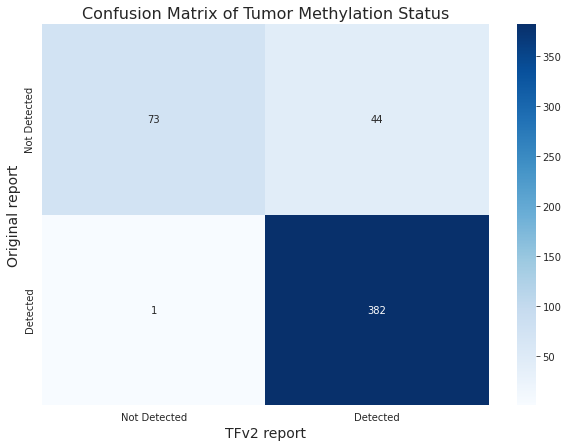

Cohen's Kappa: 0.71


In [33]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
map_status = {"Detected": 1, "Not Detected": 0}

# Map the 'Tumor_methylation_status' in both dataframes
df_sow187_2['Tumor_methylation_status_mapped'] = df_sow187_2['Tumor_methylation_status'].map(map_status)
df_sow187_final['Tumor_methylation_status_mapped'] = df_sow187_final['Tumor_methylation_status'].map(map_status)

# Merge the dataframes on GHSampleID to ensure matching entries
merged_df = pd.merge(df_sow187_2[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     df_sow187_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Filter out rows with NaN in either of the mapped status columns
valid_indices = merged_df['Tumor_methylation_status_mapped_2'].notna() & merged_df['Tumor_methylation_status_mapped_final'].notna()
y_true = merged_df[valid_indices]['Tumor_methylation_status_mapped_2'].values
y_pred = merged_df[valid_indices]['Tumor_methylation_status_mapped_final'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Original report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [159]:
df_sow187_2.Sample_status.value_counts()

SUCCESS    664
FAIL        14
Name: Sample_status, dtype: int64

In [117]:
df_sow187_2.Tumor_methylation_status.isnull().sum()

178

In [118]:
df_sow187_2.Sample_comment.value_counts()

Methylation Suppression Warning; Methylation Bias Warning                                                               79
Low Diversity Warning                                                                                                   32
Methylation Bias Warning                                                                                                16
Possible Contamination Warning                                                                                          15
Possible Contamination Warning; Methylation Suppression Warning; Methylation Bias Warning                                8
Low Diversity Warning; Unusual Coverage Profile Warning                                                                  7
Low Diversity Warning; Methylation Suppression Warning                                                                   4
Unusual Coverage Profile Warning                                                                                         4
Low Diversity Wa

## Check flipped positive calls

In [34]:
# Check the distribution of Visit_name for the flipped positive calls
df_visit = pd.merge(df_sow187_2[['GHSampleID', 'Tumor_methylation_status_mapped', 'Visit_name']],
                     df_sow187_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Create a mask for the specific case where status flips from Not Detected to Detected
mask = (df_visit['Tumor_methylation_status_mapped_2'] == 0) & (df_visit['Tumor_methylation_status_mapped_final'] == 1)
flipped_positive_samples = df_visit[mask]

# Get the MB score on positive flipped sampels
flipped_positive_samples_sample_ids = flipped_positive_samples['GHSampleID'].unique()

# Filter df_kyle_interest to find rows where run_sample_id is not in merged_sample_ids
df_flipped_pos = df_sow187_updated[df_sow187_updated['GHSampleID'].isin(flipped_positive_samples_sample_ids)]

df_flipped_pos.Visit_name.value_counts()




C2D1      14
C3D1      12
C4D1       7
SCREEN     6
C1D1       3
EOT        2
Name: Visit_name, dtype: int64

In [54]:
df_flipped_pos.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir,MB_score,pred_frac_force
475,D926UC00001,6219601159,A0992497,B00639521,E7004001,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,0.000234,NaN,NaN,NaN,NaN,1.5,0.0,01/31/2024,NaN,04/26/2024,NaN,NaN,NaN,NaN,Not Detected,2.7144,240410_A01902_0346_BH33KLDSXC,/ghsfa/ivd/flowcentral/240410_A01902_0346_BH33KLDSXC.2f699a6b-e50e-4b1c-b18b-af75b68b11ad.20240411233539,-19.439052,0.000234
485,D926UC00001,6220275991,A0992505,B00639533,E7006001,C4D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,0.000029,NaN,NaN,NaN,NaN,1.5,0.0,01/31/2024,NaN,04/26/2024,NaN,NaN,NaN,NaN,Not Detected,11.3360,240410_A01902_0346_BH33KLDSXC,/ghsfa/ivd/flowcentral/240410_A01902_0346_BH33KLDSXC.2f699a6b-e50e-4b1c-b18b-af75b68b11ad.20240411233539,-20.824421,0.000029
459,D926UC00001,6604345755,A0992500,B00639540,E6002003,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,0.000223,NaN,NaN,NaN,NaN,1.5,0.0,01/10/2024,NaN,04/26/2024,NaN,NaN,NaN,NaN,Not Detected,11.9080,240410_A01902_0346_BH33KLDSXC,/ghsfa/ivd/flowcentral/240410_A01902_0346_BH33KLDSXC.2f699a6b-e50e-4b1c-b18b-af75b68b11ad.20240411233539,-20.878772,0.000223
444,D926UC00001,6802252194,A0992466,B00639548,E4301002,C4D1,NaN,SUCCESS,Low Diversity Warning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,0.000062,NaN,NaN,NaN,NaN,1.5,0.0,01/10/2024,NaN,04/26/2024,NaN,NaN,NaN,NaN,Not Detected,2.6884,240410_A01902_0345_AH3CFWDSXC,/ghsfa/ivd/flowcentral/240410_A01902_0345_AH3CFWDSXC,-20.900944,0.000062
432,D926UC00001,6220648946,A0992479,B00639562,E2802011,C2D1,NaN,SUCCESS,Low Diversity Warning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,0.000465,NaN,NaN,NaN,NaN,1.5,0.0,01/31/2024,NaN,04/26/2024,NaN,NaN,NaN,NaN,Not Detected,4.6644,240410_A01902_0346_BH33KLDSXC,/ghsfa/ivd/flowcentral/240410_A01902_0346_BH33KLDSXC.2f699a6b-e50e-4b1c-b18b-af75b68b11ad.20240411233539,-19.982160,0.000465


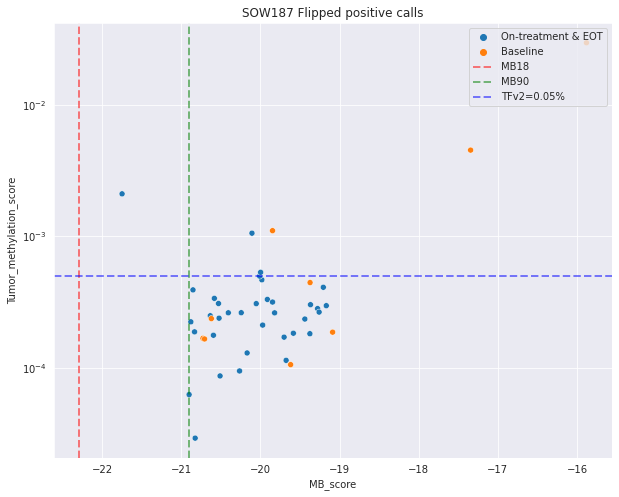

In [35]:
# Plot the distribution

df_flipped_pos['Treatment'] = np.where(
    ((df_flipped_pos['Visit_name'] == 'C1D1') | (df_flipped_pos['Visit_name'] == 'SCREEN')),
    'Baseline',
    'On-treatment & EOT'
)


plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_flipped_pos, x='MB_score', y='Tumor_methylation_score', 
                hue='Treatment')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')

# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW187 Flipped positive calls')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')



In [58]:
df_sow187_2['Treatment'] = np.where(
    ((df_sow187_2['Visit_name'] == 'C1D1') | (df_sow187_2['Visit_name'] == 'SCREEN') | (df_sow187_2['Visit_name'] == 'SCRN')),
    'Baseline',
    'On-treatment & EOT'
)

In [59]:
df_sow187_2.Treatment.value_counts()

Baseline              355
On-treatment & EOT    323
Name: Treatment, dtype: int64

In [60]:
df_sow187_2.shape

(678, 63)

In [57]:
df_sow187_2.Visit_name.value_counts()

SCREEN      200
C1D1        137
C2D1         96
C3D1         86
C4D1         77
EOT          52
SCRN         18
PROGRESS      8
ED            4
Name: Visit_name, dtype: int64

In [56]:
df_flipped_pos.Treatment.value_counts()

On-treatment & EOT    35
Baseline               9
Name: Treatment, dtype: int64

In [66]:
df_flipped_pos_bottom_right = df_flipped_pos[(df_flipped_pos['MB_score'] >= -22.289441) & (df_flipped_pos['pred_frac_force'] <= 0.0005)]
df_flipped_pos_bottom_right.Treatment.value_counts()

On-treatment & EOT    32
Baseline               6
Name: Treatment, dtype: int64

In [36]:
df_sow187_updated_pos = df_sow187_updated[df_sow187_updated['Tumor_methylation_status'] == 'Detected']

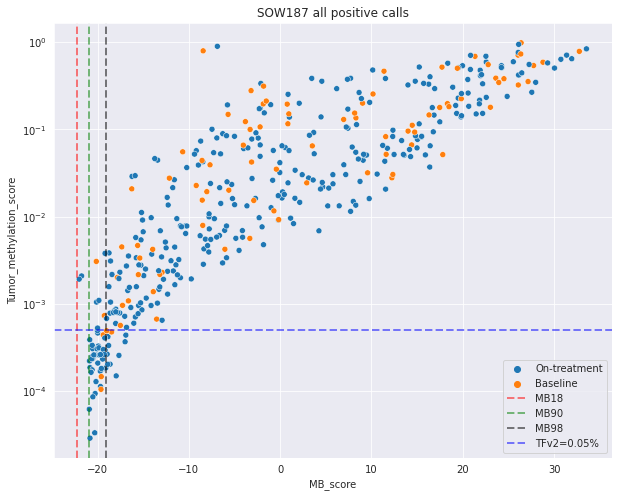

In [38]:
# Plot the distribution of all positive calls on this TFv2 update

df_sow187_updated_pos['Treatment'] = np.where(
    (df_sow187_updated_pos['Visit_name'] == 'C1D1'),
    'Baseline',
    'On-treatment'
)

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow187_updated_pos, x='MB_score', y='Tumor_methylation_score', 
                hue='Treatment')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684; MB98: -19.0509)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')
plt.axvline(x=-19.0509, color='black', linestyle='--', linewidth=2, alpha=0.5, label='MB98')

# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW187 all positive calls')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')



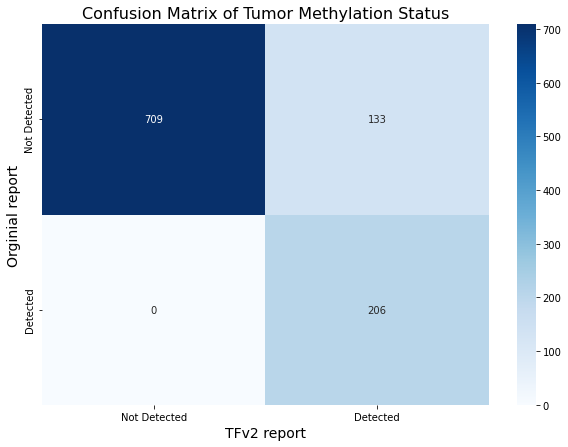

Cohen's Kappa: 0.68


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow176_monitoring_all['Tumor_methylation_status_mapped'] = df_sow176_monitoring_all['Tumor_methylation_status'].map(map_status)
df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'] = df_sow176_monitoring_final_all['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow176_monitoring_all['Tumor_methylation_status_mapped'].notna() & df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'].notna()
y_true = df_sow176_monitoring_all[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow176_monitoring_final_all[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [ ]:
# Create a mask for the specific case
mask = (df_sow176_monitoring_all['Tumor_methylation_status_mapped'] == 0) & (df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow176_monitoring_final_all[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C3D1    52
C7D1    48
C9D1    33
Name: Visit_name, dtype: int64


In [ ]:
df_sow176_monitoring_final_all.Visit_name.value_counts()

C9D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

In [ ]:
# Remove duplication for infinity final
df_sow176_infinity_dedup = df_sow176_ori_1.drop_duplicates(subset = "GHSampleID")
df_sow176_infinity_final_dedup = df_sow176_infinity_final_all.drop_duplicates(subset = "GHSampleID")

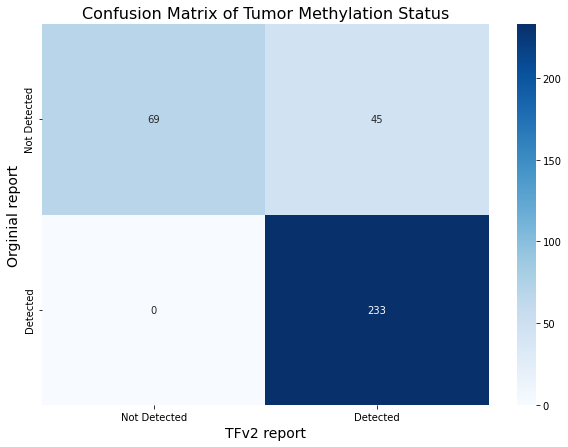

Cohen's Kappa: 0.67


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow176_infinity_dedup['Tumor_methylation_status_mapped'] = df_sow176_infinity_dedup['Tumor_methylation_status'].map(map_status)
df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'] = df_sow176_infinity_final_dedup['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow176_infinity_dedup['Tumor_methylation_status_mapped'].notna() & df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'].notna()
y_true = df_sow176_infinity_dedup[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow176_infinity_final_dedup[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [ ]:
# Create a mask for the specific case
mask = (df_sow176_infinity_dedup['Tumor_methylation_status_mapped'] == 0) & (df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow176_infinity_final_dedup[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C1D1    45
Name: Visit_name, dtype: int64


In [ ]:
df_sow176_final.Visit_name.value_counts()

C1D1    352
C9D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

In [ ]:
df_sow176_2.Visit_name.value_counts()

C9D1    352
C1D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

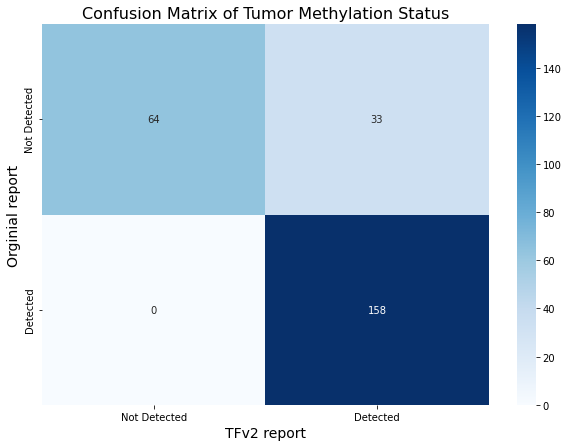

Cohen's Kappa: 0.71


In [179]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow187_monitoring_all['Tumor_methylation_status_mapped'] = df_sow187_monitoring_all['Tumor_methylation_status'].map(map_status)
df_sow187_monitoring_final_all['Tumor_methylation_status_mapped'] = df_sow187_monitoring_final_all['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow187_monitoring_all['Tumor_methylation_status_mapped'].notna() & df_sow187_monitoring_final_all['Tumor_methylation_status_mapped'].notna()
y_true = df_sow187_monitoring_all[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow187_monitoring_final_all[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [180]:
df_sow187_monitoring_all.Sample_status.value_counts()

SUCCESS    255
FAIL         4
Name: Sample_status, dtype: int64

In [161]:
# Create a mask for the specific case
mask = (df_sow187_monitoring_all['Tumor_methylation_status_mapped'] == 0) & (df_sow187_monitoring_final_all['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow187_monitoring_final_all[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C2D1    14
C3D1    12
C4D1     7
Name: Visit_name, dtype: int64


In [189]:
df_sow187_infinity_final_all.shape

(17285, 56)

In [184]:
df_sow187_infinity_dedup = df_sow187_infinity_all.drop_duplicates(subset = "GHSampleID")
df_sow187_infinity_final_dedup = df_sow187_infinity_final_all.drop_duplicates(subset = "GHSampleID")


In [190]:
# Drop duplicates and set 'GHSampleID' as the new index for df_sow187_infinity
df_sow187_infinity_dedup = df_sow187_infinity_all.drop_duplicates(subset="GHSampleID").set_index('GHSampleID')

# Drop duplicates and set 'GHSampleID' as the new index for df_sow187_infinity_final
df_sow187_infinity_final_dedup = df_sow187_infinity_final_all.drop_duplicates(subset="GHSampleID").set_index('GHSampleID')

# Check if both dataframes now have the same index order and missing values
print("Indices matched:", df_sow187_infinity_dedup.index.equals(df_sow187_infinity_final_dedup.index))


Indices matched: True


In [192]:
df_sow187_infinity_dedup.Sample_status.value_counts()

SUCCESS    332
FAIL         8
Name: Sample_status, dtype: int64

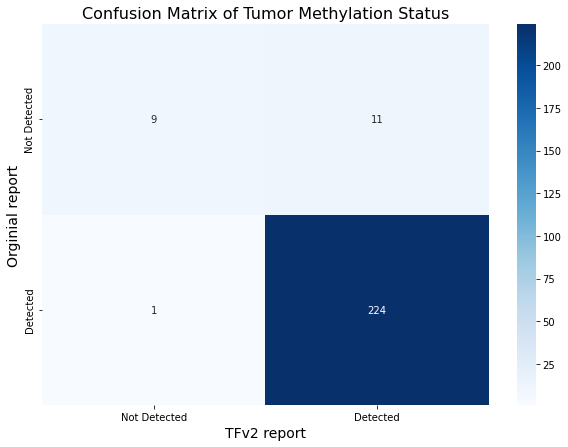

Cohen's Kappa: 0.58


In [191]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow187_infinity_dedup['Tumor_methylation_status_mapped'] = df_sow187_infinity_dedup['Tumor_methylation_status'].map(map_status)
df_sow187_infinity_final_dedup['Tumor_methylation_status_mapped'] = df_sow187_infinity_final_dedup['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow187_infinity_dedup['Tumor_methylation_status_mapped'].notna() & df_sow187_infinity_final_dedup['Tumor_methylation_status_mapped'].notna()
y_true = df_sow187_infinity_dedup[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow187_infinity_final_dedup[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [164]:
# Create a mask for the specific case
mask = (df_sow187_infinity_dedup['Tumor_methylation_status_mapped'] == 0) & (df_sow187_infinity_final_dedup['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow187_infinity_final_dedup[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


SCREEN    6
C1D1      3
EOT       2
Name: Visit_name, dtype: int64


In [182]:
df_sow187_infinity_dedup.Sample_status.value_counts()

SUCCESS    332
FAIL         8
Name: Sample_status, dtype: int64

In [181]:
df_sow187_infinity_dedup.shape

(340, 57)

In [176]:
df_sow187_monitoring_all.shape

(259, 20)

In [178]:
df_sow187_monitoring_all.Visit_name.value_counts()

C2D1    96
C3D1    86
C4D1    77
Name: Visit_name, dtype: int64

In [174]:
df_sow187_2.shape

(678, 62)

# SOW197 TFv2 update (HNSCC)

## Data preocessing

In [484]:
# Readin cummulative reports 

# SOW need to check the different versions of the delivered report
df_sow197_all = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20240809_AstraZeneca_SOW197_30Samples_InfinityReport.csv", header = 1) 

print("Total sample size of SOW197 Infinity cumulative batches is " + str(df_sow197_all.shape[0]) + "\n") 
print("Total unique sample size of SOW197 Infinity cumulative batches is " + str(df_sow197_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW197 Infinity cumulative batches is " + str(df_sow197_all.Patient_ID.nunique()) + "\n")

df_sow197_all.head()

Total sample size of SOW197 Infinity cumulative batches is 813

Total unique sample size of SOW197 Infinity cumulative batches is 30

Total unique patient sample size of SOW197 Infinity cumulative batches is 6



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
1,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,TNK2,3,195594512.0,12,R871H,C>T,c.2612G>A,NM_005781.5,41.89,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs763752077,NaN,NaN,NaN,NaN,2582.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
2,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,TRAF3,14,103352540.0,6,T195T,C>T,c.585C>T,NM_003300.4,40.70,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs186117694,NaN,NaN,NaN,NaN,3125.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
3,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,RECQL,12,21627845.0,11,M429V,T>C,c.1285A>G,NM_002907.4,40.09,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs368679142,NaN,NaN,NaN,NaN,2880.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
4,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ZNF217,20,52193081.0,4,K741R,T>C,c.2222A>G,NM_006526.3,39.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs569839543,NaN,NaN,NaN,NaN,2563.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable


In [485]:
# Remove duplication
df_sow197_dedup = df_sow197_all.drop_duplicates(subset = "GHSampleID")
df_sow197_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
64,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.006236,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
138,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.016373,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
197,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
214,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002153,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable


In [486]:
df_sow197_dedup.Cancertype.value_counts()

HNSCC    30
Name: Cancertype, dtype: int64

In [487]:
# Pull "runid" from ghdb
df_sow197_1 = df_sow197_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow197_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow197_1 = df_sow197_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow197_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC
1,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.006236,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC
2,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.016373,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC
3,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC
4,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002153,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC


In [488]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow197_2, df_no_found = add_fc_dir_column(df_sow197_1)

print("Total sample size of SOW197 Infinity cumulative batches with fc_dir is " + str(df_sow197_2.shape[0]) + "\n") 
print("Total sample size of SOW197 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow197_2.head()



Total sample size of SOW197 Infinity cumulative batches with fc_dir is 30

Total sample size of SOW197 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC
1,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.006236,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC
2,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.016373,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC
3,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC
4,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002153,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC


## Generate Pancancer S3 MB caller outputs for this SOW
#### Notes:
    1. No cancer type provided
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [114]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW197_jobs"
    output_dir = f"{workdir}/MB_module_SOW197_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=60gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=01:00:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [7]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_sow197_2, 
                      f"{work_dir}")

Submitted batch job 87136955
Submitted batch job 87136956
Submitted batch job 87136957
Submitted batch job 87136958
Submitted batch job 87136959
Submitted batch job 87136960
Submitted batch job 87136961
Submitted batch job 87136962
Submitted batch job 87136963
Submitted batch job 87136964
Submitted batch job 87136965
Submitted batch job 87136966
Submitted batch job 87136967
Submitted batch job 87136968
Submitted batch job 87136969
Submitted batch job 87136970
Submitted batch job 87136971
Submitted batch job 87136972
Submitted batch job 87136973
Submitted batch job 87136974
Submitted batch job 87136975
Submitted batch job 87136976
Submitted batch job 87136977
Submitted batch job 87136978
Submitted batch job 87136979
Submitted batch job 87136980
Submitted batch job 87136981
Submitted batch job 87136982
Submitted batch job 87136983
Submitted batch job 87136984


In [489]:
# Retrieve MB S3 Pancancer caller score

df_sow197_3 = df_sow197_2.copy()

df_sow197_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW197_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow197_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow197_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow197_3.loc[problematic_rows]

print("Total sample size of SOW197 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow197_3.head()


Total sample size of SOW197 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-11.353623
1,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.006236,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-6.940209
2,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.016373,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-3.968238
3,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-22.126375
4,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002153,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-12.335708


## Generate the epiTFv2 gamma score results

In [490]:
# Temporary solution for TFv2gamma score generation
df_sow197_3 = df_sow197_3[df_sow197_3['Sample_status'] != "FAIL"]
df_sow197_3.shape

# Save the data
df_sow197_3.to_csv(f"{work_dir}/df_sow197_3.csv", index = False)

In [25]:
# Step 1: save the input csv file
df_sow197_3 = pd.read_csv(f"{work_dir}/df_sow197_3.csv", header = 0)
df_sow197_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW197_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [26]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow197_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow197.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [27]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow197.sh")

Submitted batch job 87501030


0

In [491]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow197_4 = df_sow197_3[df_sow197_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow197_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW197_output"

for index, row in df_sow197_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow197_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW197 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow197_5 = df_sow197_4.copy()
df_sow197_5.head()

Total sample size of SOW197 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001851,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-11.353623,0.001915
1,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.006236,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-6.940209,0.070738
2,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.016373,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-3.968238,0.223826
3,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-22.126375,0.000059
4,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002153,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-12.335708,0.002366


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [492]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684
df_sow197_updated = update_tumor_methylation_status(df_sow197_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow197_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-11.353623,0.001915
1,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.070738,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-6.940209,0.070738
2,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.223826,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-3.968238,0.223826
3,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-22.126375,0.000059
4,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002366,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable,240720_A01020_0846_BHJ32LDSXC,/ghsfa/ivd/flowcentral/240720_A01020_0846_BHJ32LDSXC,-12.335708,0.002366


In [493]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow197_5_sub = df_sow197_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow197_5_sub_dedup = df_sow197_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW197 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow197_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow197_all_dedup = df_sow197_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW197 Infinity cumulative batches is " + str(df_sow197_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow197_all_dedup.Sample_status.value_counts()


Total sample size of SOW197 Infinity cumulative batches with updated MB score and TFv2gamma is 29

Total sample size of original SOW197 Infinity cumulative batches is 30



SUCCESS    29
FAIL        1
Name: Sample_status, dtype: int64

In [494]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow197_all_dedup.merge(df_sow197_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow197_final = df_merged[df_sow197_all_dedup.columns]

# Save the data
df_sow197_final.to_csv(f"{work_dir}/df_sow197_final.csv", index = False)

df_sow197_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
1,MATRIX_HNSCC,FB12680088,A1086305,B00713441,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,PRKN,6,161771240.0,12,G430D,C>T,c.1289G>A,NM_004562.3,47.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs191486604,NaN,NaN,NaN,NaN,2195.0,8.33,NaN,NaN,Detected,0.070738,NaN,Not evaluable,Not Detected,18.16,3.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
2,MATRIX_HNSCC,FB12679892,A1086306,B00713443,HN_Set-5,NaN,1,SUCCESS,NaN,SNV,NaN,BSG,19,577996.0,2,T97M,C>T,c.290C>T,NM_001728.4,41.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs142446858,NaN,NaN,NaN,NaN,2709.0,14.61,NaN,NaN,Detected,0.223826,NaN,Not evaluable,Not Detected,25.46,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
3,MATRIX_HNSCC,FB12679870,A1086307,B00713437,HN_Set-4,NaN,1,SUCCESS,NaN,SNV,NaN,ARID1A,1,27023366.0,1,P158S,C>T,c.472C>T,NM_006015.6,54.12,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV105203301,rs567246585,Likely_benign,363748.0,NaN,NaN,495.0,0.52,NaN,NaN,Not Detected,0.0,NaN,Not evaluable,Not Detected,13.61,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
4,MATRIX_HNSCC,FB12778707,A1086308,B00713438,HN_Set-1,NaN,1,SUCCESS,NaN,SNV,NaN,CD79A,19,42383351.0,2,R124H,G>A,c.371G>A,NM_001783.4,51.41,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55737919,rs144367487,Uncertain_significance,137573.0,NaN,NaN,1116.0,1.40,NaN,NaN,Detected,0.002366,NaN,Not evaluable,Not Detected,6.77,4.0,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable


In [495]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow197_all.merge(df_sow197_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow197_final_all = df_merged[df_sow197_all.columns]

# Save the data
df_sow197_final_all.to_csv(f"{work_dir}/20240924_AstraZeneca_SOW197_30Samples_TFv2_InfinityReport.csv", index = False)

df_sow197_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ETV1,7,13971252.0,9,G226A,C>G,c.677G>C,NM_004956.5,42.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3242.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
1,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,TNK2,3,195594512.0,12,R871H,C>T,c.2612G>A,NM_005781.5,41.89,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs763752077,NaN,NaN,NaN,NaN,2582.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
2,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,TRAF3,14,103352540.0,6,T195T,C>T,c.585C>T,NM_003300.4,40.70,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs186117694,NaN,NaN,NaN,NaN,3125.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
3,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,RECQL,12,21627845.0,11,M429V,T>C,c.1285A>G,NM_002907.4,40.09,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs368679142,NaN,NaN,NaN,NaN,2880.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable
4,MATRIX_HNSCC,FB12680481,A1086304,B00713440,HN_Set-6,NaN,1,SUCCESS,NaN,SNV,NaN,ZNF217,20,52193081.0,4,K741R,T>C,c.2222A>G,NM_006526.3,39.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs569839543,NaN,NaN,NaN,NaN,2563.0,6.33,NaN,NaN,Detected,0.001915,NaN,Not evaluable,Not Detected,19.21,3.5,0.0,06/11/2024,NaN,08/09/2024,HNSCC,Not Applicable,Not Applicable


In [496]:
df_sow197_final_all.shape

(813, 56)

In [498]:
df_sow197_final_all.GHSampleID.nunique()

30

In [497]:
df_sow197_final.shape

(30, 56)

In [24]:
# Add TFv2 suppression rule. Apply secondary rule to corrct TFv2 score > 1 to 0.99
df_sow197_final_all = pd.read_csv(f"{work_dir}/20240924_AstraZeneca_SOW197_30Samples_TFv2_InfinityReport.csv")

# Ad-hoc process
df_sow197_final_all_new = suppress_methylation_score_higher_than_1(df_sow197_final_all)

# Save the data
df_sow197_final_all_new.to_csv(f"{work_dir}/20241104_AstraZeneca_SOW197_30Samples_TFv2_InfinityReport.csv", index = False)

## Data Visualization

### Confusion Matrix

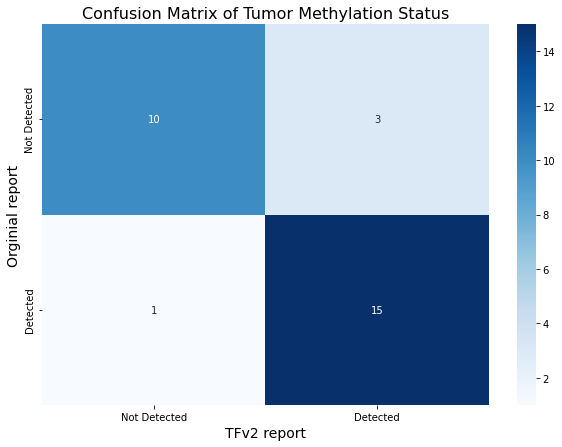

Cohen's Kappa: 0.72


In [499]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow197_2['Tumor_methylation_status_mapped'] = df_sow197_2['Tumor_methylation_status'].map(map_status)
df_sow197_final['Tumor_methylation_status_mapped'] = df_sow197_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow197_2['Tumor_methylation_status_mapped'].notna() & df_sow197_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow197_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow197_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")
